# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

## Data Validation
- ✔️ All the columns have been validated.
- ✔️ No duplicates were found.
- ✔️ All the recipes (and the recipes' ID's) are unique.
- ✔️ All the numerical columns are non-negative.
- ✔️ Target variable (high_traffic) and Category feature are indeed character.
- ❌ Invalid category value in Category feature - "Chicken Breast".
   - ✔️ Such category value was merged with the category "Chicken".
- ❌ Invalid data type of Servings feature - was encoded as character instead of numeric.
- ❌ Invalid values in Servings feature - instead of numbers, there were 2 values "4 as a snack" and "6 as a snack".
   - ✔️ Such values were merged with values "4" and "6" respectively.
   - ✔️ Conversion from character to numeric.
- ✔️ Target variable (High traffic) had missing values indicating no high traffic.
   - ✔️ Thus, we replace the missing values with 'Low'.
- ✔️ Recipe ID column was dropped from the dataset, since it wouldn't bring any useful information for modelling.

Installing and importing relevant libraries

In [1]:
!pip install category-encoders
!pip install keras-tuner
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 12.6 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 23.4 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.7 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr, ks_2samp, somersd
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import ADASYN
from sklearn.impute import KNNImputer
from category_encoders.woe import WOEEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import BayesianOptimization
from keras_tuner import Objective
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, brier_score_loss, zero_one_loss

2023-03-19 01:00:54.479856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-19 01:00:54.479879: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Reading data

In [3]:
data = pd.read_csv('recipe_site_traffic_2212.csv')

NameError: name 'pd' is not defined

Displaying the data
- we can observe some missing values

In [4]:
data

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


The dataset has 7 columns and 947 rows

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


Duplicates check - no duplicates detected:

In [6]:
print(data.duplicated().sum())

0


In [7]:
print(data.duplicated(subset = data.drop('high_traffic',axis=1).columns).sum())

0


In [8]:
def check_dtype(df: pd.DataFrame, col: str, col_dtype: str):
    
    dtype_funcs = {'numeric': pd.api.types.is_numeric_dtype,
                  'character': pd.api.types.is_string_dtype}
    
    if dtype_funcs[col_dtype](df[col]):
        print(f'Column "{col}" is indeed {col_dtype}.')
        
    else:
        col_dtype_print = 'character' if df[col].dtype == 'O' else 'numeric'
        print(f'Column "{col}" is not {col_dtype} but {col_dtype_print}.')

### Recipe

Check whether a **recipe** column is numeric according to the validation description. (_it is indeed_)

In [9]:
check_dtype(data, 'recipe', 'numeric')

Column "recipe" is indeed numeric.


Check whether all the values of **recipe** column are unique according to the validation description. (_they are indeed_)

In [10]:
assert data['recipe'].nunique() == data.shape[0]

### Calories

Check whether a **calories** column is numeric  according to the validation description. (_it is indeed_)

In [11]:
check_dtype(data, 'calories', 'numeric')

Column "calories" is indeed numeric.


Check whether the calories are all positive (since a calorie is a unit energy which cannot be negative) -> _(They are all positive)_

In [12]:
assert data['calories'].min() >= 0.0

### Carbohydrate

Check whether a **carbohydrate** column is numeric (_it is indeed_)

Check whether the carbohydrates are all positive (since the carbohydrate number is a present amount which cannot be negative) -> _(They are all positive)_

In [13]:
check_dtype(data, 'carbohydrate', 'numeric')

Column "carbohydrate" is indeed numeric.


In [14]:
assert data['carbohydrate'].min() >= 0.0

### Sugar

Check whether a **sugar** column is numeric according to the validation description.  (_it is indeed_)

Check whether the sugar valuies are all positive (since the sugar values are weigth amounts which cannot be negative) -> _(They are all positive)_

In [15]:
check_dtype(data, 'sugar', 'numeric')

Column "sugar" is indeed numeric.


In [16]:

assert data['sugar'].min() >= 0.0

### Protein

Check whether a **protein** column is numeric according to the validation description.  (_it is indeed_)

In [17]:
check_dtype(data, 'protein', 'numeric')

Column "protein" is indeed numeric.


Check whether the protein valuies are all positive (since the protein values are weigth amounts which cannot be negative) -> _(They are all positive)_

In [18]:
assert data['protein'].min() >= 0.0

### Category

Check whether a **category** column is character according to the validation description.  (_it is indeed_)

In [19]:
check_dtype(data, 'category', 'character')

Column "category" is indeed character.


We need to also check whether **category** has the valid categories according to the validation description.
- those are the valid categories:

In [20]:
valid_categories = ['Lunch/Snacks', 'Beverages', 'Potato','Vegetable', 'Meat',
                    'Chicken', 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal']
valid_categories

['Lunch/Snacks',
 'Beverages',
 'Potato',
 'Vegetable',
 'Meat',
 'Chicken',
 'Pork',
 'Dessert',
 'Breakfast',
 'One Dish Meal']

And those are the categories from the provided data:

In [21]:
actual_categories = sorted(data['category'].value_counts(dropna = False).index.tolist())
actual_categories

['Beverages',
 'Breakfast',
 'Chicken',
 'Chicken Breast',
 'Dessert',
 'Lunch/Snacks',
 'Meat',
 'One Dish Meal',
 'Pork',
 'Potato',
 'Vegetable']

As can be seen, there is one invalid category "Chicken Breast"

In [22]:
invalid_categories = list(set(valid_categories) - set(actual_categories)) +\
                     list(set(actual_categories) - set(valid_categories))

invalid_categories

['Chicken Breast']

Since chicken breast is apparently a chicken, we then replace "Chicken Breast" categories with "Chicken".

In [23]:
data['category'] = data['category'].replace('Chicken Breast', 'Chicken')

In [24]:
data['category'].value_counts(dropna = False)

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

### Servings

Check whether a **servings** column is numeric according to the validation description.
- As can be seen, the **servings** values are encoded as character instead of as numeric. Therefore, we have to convert such values into numerical ones, particularly into integers.

In [25]:
check_dtype(data, 'servings', 'numeric')

Column "servings" is not numeric but character.


Before any conversion, we need to check its unique values.
- As can be seen, besides the numerical values, we have 2 values which also contain text - namely "4 as a snack", "6 as a snack".
- One would say that we shall treat them as a separate/differrent values, but since their freuqencies sum up to 3 observations only, therefore we merge those values with their respective values - thus, "4 as a snack" values with "4" values, and "6 as a snack" with "6" values.
- We as well convert such character values into numerical ones within the list comprehension.

In [26]:
data['servings'].value_counts(dropna = False)

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [27]:
data['servings'] = [int(i[0]) if len(i) > 1 else int(i) for i in data['servings']]

In [28]:
#Cleaned values
data.servings.value_counts(dropna = False)

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

Let us check the data type again - such column is indeed numeric after such operations.

In [29]:
check_dtype(data, 'servings', 'numeric')

Column "servings" is indeed numeric.


**High traffic**

Check whether a **high_traffic** column is character according to the validation description.  (_it is indeed_)

In [30]:
check_dtype(data, 'high_traffic', 'character')

Column "high_traffic" is indeed character.


We need to also validate its categories - if the traffic to the site was high when such recipe was shown, it should be labelled as "High"
- That is indeed true, but for further operations, we need to treat the missing values - since they are indicating that the traffic was not high, therefore we imput such missing values with category "Low".

In [31]:
data['high_traffic'].value_counts(dropna = False)

High    574
NaN     373
Name: high_traffic, dtype: int64

In [32]:
data['high_traffic'] = data['high_traffic'].fillna('Low')

In [33]:
data['high_traffic'].value_counts(dropna = False)

High    574
Low     373
Name: high_traffic, dtype: int64

### Other cleaning tasks

Since **recipe** column is just ID column and doesn't capture any useful information for modelling, thus we drop from the data.
- Also, we beforehand set other parameters such as random seed, target variable name, lists of categorical/numeric features for further operations.

In [34]:
data.drop('recipe', axis = 1, inplace = True, errors = 'ignore')

target = 'high_traffic'
cat_features = [i for i in data.columns if data[i].dtype == 'O' and i != target]
num_features = [i for i in data.columns if i not in cat_features and i != target]

print(f'Target variable: {target}')
print(f'Categorical features: {", ".join(cat_features)}')
print(f'Numerical features: {", ".join(num_features)}')

cat = cat_features[0]

Target variable: high_traffic
Categorical features: category
Numerical features: calories, carbohydrate, sugar, protein, servings


## Exploratory Analysis
- **Target variable distribution (High traffic)**
  - Imbalanced distribution - 60.6% of high traffic recipes ands 39.4% of low traffic recipes.
- **Category feature**
  - Most of the recipes included chicken (172 out of 947).
  - Most of the recipes including pork, potatoes vegetables or meat mostly leaded to the website's high traffic.
  - Most of the recipes including breakfast, beverages or chicken mostly didn't lead to the website's high traffic.
  - We expect such categories will help us to distinguish the high traffic and low traffic recipes within modelling.
  - Moderate and statistically significant association between the high traffic and the category.
- **Numerical features**
  - Servings features is discrete, whereas other numerical features (calories, carbohydrate, sugar, protein) are continuous.
  - Most of the recipes were meant for 4 servings.
  - Most of the recipes had very low level of either calories, carbohydrate, sugar and/or protein (their distributions were positively skewed.)
  - No pattern were found in terms of relation to high traffic.
  - Very weak and statistically insignificant association between the high traffic and the numerical features.
  - No multicolinearity observed.
- **N/A analysis**
  - 4 features (calories, carbohydrate, sugar and protein) had missing values (52).
  - 52 recipes had missing values - all the N/A's pertained to the same recipes.
  - Very weak and statistically insignificant association between the missing occurrences and the target variable. 

### Target variable distribution (High traffic)

As can be seen, the target distribution is quite imbalanced, meaning that there is a significant proporition of 1 class with respect to the other one.
- Particularly, we see that about 60% of recipes had high traffic to the site when they were shown.
- Anyway, such imbalanced class issue will be dealt during the modelling part.

In [35]:
data[target].value_counts(normalize = True)

High    0.606125
Low     0.393875
Name: high_traffic, dtype: float64

In [36]:
def target_dist(data:pd.DataFrame, target:str):
    
    plt.figure(figsize = (8, 6))
    
    sns.countplot(data, x = target)
    plt.title("Distribution of the recipes' sites traffices",
              fontweight = 'bold')
    
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    plt.show()

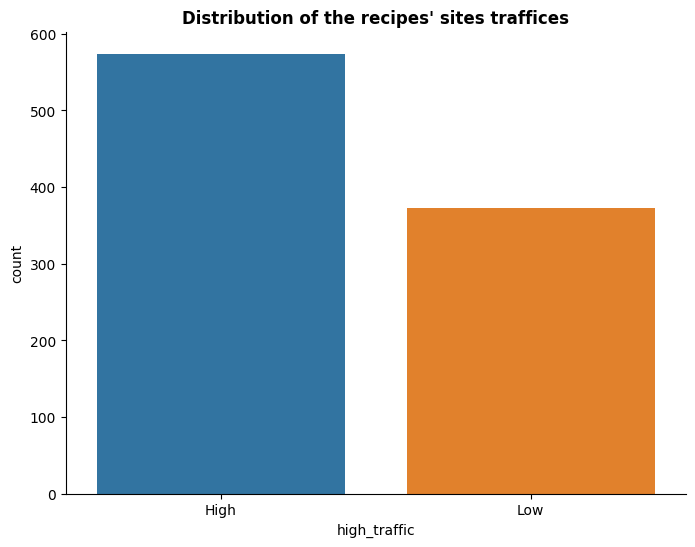

In [37]:
target_dist(data, target)

### Categorical feature(s) distribution

We also plot a frequency plot of categorical feature, both unconditional and conditional on the target variable.

In [38]:
def cat_dist(data:pd.DataFrame, cat:str, target:str = ''):
    
    plt.figure(figsize=(8, 6))
    
    #Unconditional distribution (if target name is not passes)
    if target == '':
        sns.countplot(data, x = cat)
        plt.title("Unconditional Distribution of Category Feature",
                  fontweight = "bold")
   
    #Conditional distribution (if target is passed)
    else:
        sns.countplot(data, x = cat, hue = target)
        plt.title("Conditional Distribution of Category Feature on Target",
                  fontweight = "bold")

    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.tick_params(axis = 'x', rotation  = 60)

    

    plt.show()

Within the unconditional distribution, we can observe that the most frequent recipes include chicken. The true question is - is really true amongst the popular recipes as well?

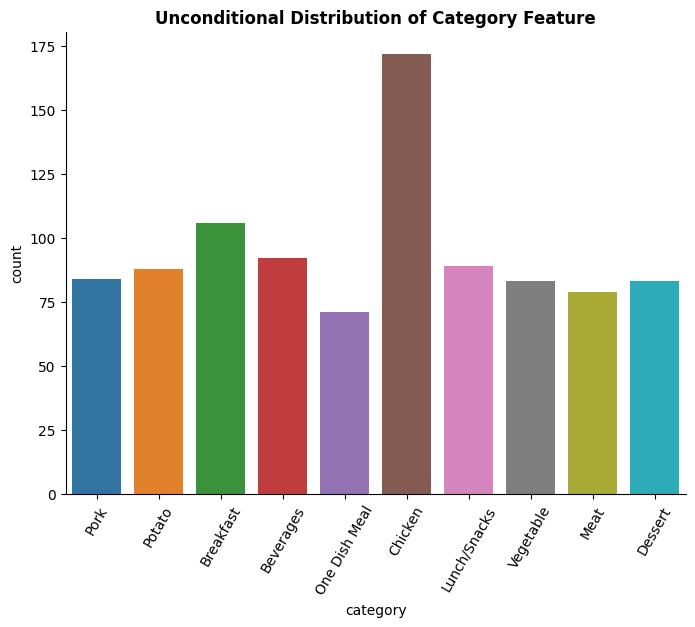

In [39]:
cat_dist(data, cat)

Within the conditional feature distribution, we see that chicken dominancy has disappeared in terms of comparison to the low traffic with respect to the chicken.
- On the other hand, recipes including pork, potato, vegetable or meat have a lot of recipes with high traffic compared to the low traffic ones within given category -> we expect such categories would be the main drivers of the high traffic of recipes.
- In contrast, recipes including breakfast, beverages or even chicken had mostly low traffic!

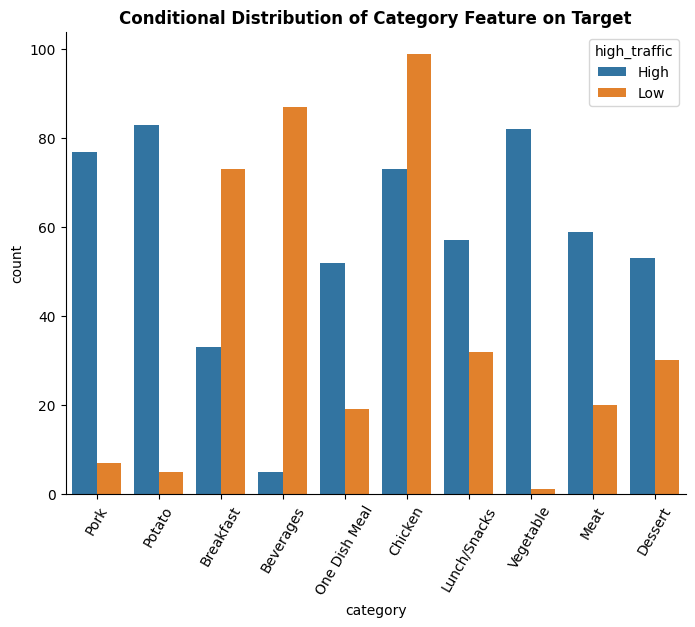

In [40]:
cat_dist(data, cat, target)

### Association between the target and categorical feature(s)

To measure an association between the two categorical variables, we can use Chi square test, namely Cramer V and the Chi square statistic.



The Cramer's V can be computed as:
$$V_{cr} = \sqrt{\frac{\chi^2}{N(k-1)}}$$
- Cramer's V ranges from 0 to 1 ... the higher score, the stronger association.
- Chi square statistic, particularly its p-value is compared to the significance level (1%) ... if the p-value is below the significance level, we deem the the association statistically significant on the 1% significance level.

In [51]:
def cat_target_association(var1, var2, significance_level = 0.01):
    
    #priting options
    no_dashes = 100
    
    #contingency/frequency table
    cont_table = pd.crosstab(var1, var2)
    
    #computed chi squared statistic and the p-valule
    chi2, p_value, *_ = chi2_contingency(cont_table)
    
    #number of observations
    N = cont_table.sum().sum()
    #minimal dimension
    k = min(cont_table.shape)
    
    #final Cramer's V
    cramer_v = np.sqrt((chi2/N) / (k-1))
    
    #Priting results
    result_significance = '' if p_value <= significance_level else 'not '
    result_strength = 'weak' if cramer_v <= 0.2 else 'moderate' if cramer_v <= 0.6 else 'strong'
    significance_level_print = int(significance_level*100) if (significance_level*100).is_integer() else significance_level*100
    
    print(f"{no_dashes*'-'}")
    
    print(f"Cramer's V: {cramer_v}")
    print(f"Chi squared statistic: {chi2}")
    print(f"p-value: {p_value}")
    
    print(f"{no_dashes*'-'}")
    
    print(f"RESULT: The association is {result_strength} and is {result_significance}statistically significant on the {significance_level_print}% significance level.")
    
    print(f"{no_dashes*'-'}")

As can be seen, we can observe a moderate (almost strong) association between the **category** feature and the **high traffic** target, which is also statistically significant.

In [52]:
cat_target_association(data[target], data[cat])

----------------------------------------------------------------------------------------------------
Cramer's V: 0.57974753481689
Chi squared statistic: 318.2935223075693
p-value: 3.417304408371004e-63
----------------------------------------------------------------------------------------------------
RESULT: The association is moderate and is statistically significant on the 1% significance level.
----------------------------------------------------------------------------------------------------


### Numerical features distribution

Distribution of numerical features, both unconditional and conditional on the target variable.

In [53]:
def num_dist(data:pd.DataFrame, num_features:list, plot_type:str, target:str = ''):
    
    #Boxplot:
    if plot_type == 'boxplot':
        
        fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
        
        #Unconditional distribution
        if target == '':
            
            for var, ax in zip(num_features, axs.ravel()):
                
                sns.boxplot(data, y = var, ax = ax)
                ax.set_title(f'Distribution of {var}')
                ax.set(xlabel = None)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                
            plt.suptitle("Unconditional Distribution of Numeric Features", fontweight = 'bold')
            fig.delaxes(axs[2][1])
        
        #Conditional distribution
        else:
            for var, ax in zip(num_features, axs.ravel()):
                
                sns.boxplot(data, y = var, ax = ax, x = target)
                ax.set_title(f'Distribution of {var}')
                ax.set(xlabel = None)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                
            plt.suptitle("Conditional Distribution of Numeric Features on Target", fontweight = 'bold')
            fig.delaxes(axs[2][1])

            
    #Histogram:
    if plot_type == 'histogram':            
        bins_dict = {}
        
        #Calculating the bin size for given feature ensuring that both conditional plots (left and right) will have the same number of bins.
        #Using rule of thumb (Scott, 1979) - https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
        for var in num_features:
            var_series = data[var]
            R = var_series.max() - var_series.min()
            n = len(var_series)
            sigma = var_series.std()
            no_bins = int( R * (n ** (1/3) ) / (3.49 * sigma))
    
            bins_dict[var] = {'no_bins': no_bins, 'binrange': ((var_series.min(), var_series.max()))}
        
        #Unconditional distribution
        if target == '':
            fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
            for var, ax in zip(num_features, axs.ravel()):
                
                var_no_bins = bins_dict[var]['no_bins']
                var_binrange = bins_dict[var]['binrange']
    
                sns.histplot(data, x = var, ax = ax, kde = True, bins = var_no_bins, binrange = (var_binrange))
        
                ax.set_title(f'Distribution of {var}')
                ax.set(xlabel = None)
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
            
            plt.suptitle("Unconditional Distribution of Numeric Features", fontweight = 'bold')
            fig.delaxes(axs[2][1])
       
        #Conditional distribution
        else:
            fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (10, 15))
            col_ind, axis_count = 0, 0
            
            for ax in axs.ravel():
                
                var = num_features[col_ind]
                var_no_bins = bins_dict[var]['no_bins']
                var_binrange = bins_dict[var]['binrange']
                
                #Conditional distribution given the target == 'High'
                if axis_count % 2 == 0:

                    df_subset = data.query(f'{target} == "High"')
                    sns.histplot(df_subset, x = var, ax = ax, kde = True, bins = var_no_bins, binrange = var_binrange)
                    ax.set_title(f'Distribution of {var} (High traffic)')
                    ax.set(xlabel = None)
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                
                #Conditional distribution given the target == 'Low'
                else:

                    df_subset = data.query(f'{target} == "Low"')
                    sns.histplot(df_subset, x = var, ax = ax, kde = True, bins = var_no_bins, binrange = var_binrange)
                    ax.set_title(f'Distribution of {var} (Low traffic)')
                    ax.set(xlabel = None)
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
        
                    col_ind += 1
                axis_count += 1

            plt.suptitle("Conditional Distribution of Numeric Features on Target", fontweight = 'bold')


    plt.tight_layout()
    plt.subplots_adjust(top = 0.93)
    plt.show()
   

From the unconditional plots below, we can observe that most of the features are continuous (with expection of servings column).
- With expection of the servings column, the features are right skewed (lot of values are nearby 0), containing various outliers in the heavy tail. Meaning the most of the recipes has very low (or none) calories, carbohydrates, sugar and/or protein.
- The servings feature seems to be discrete (the number cannot be float) - as can be seen, the most of the recipes are meant for 4 servings.

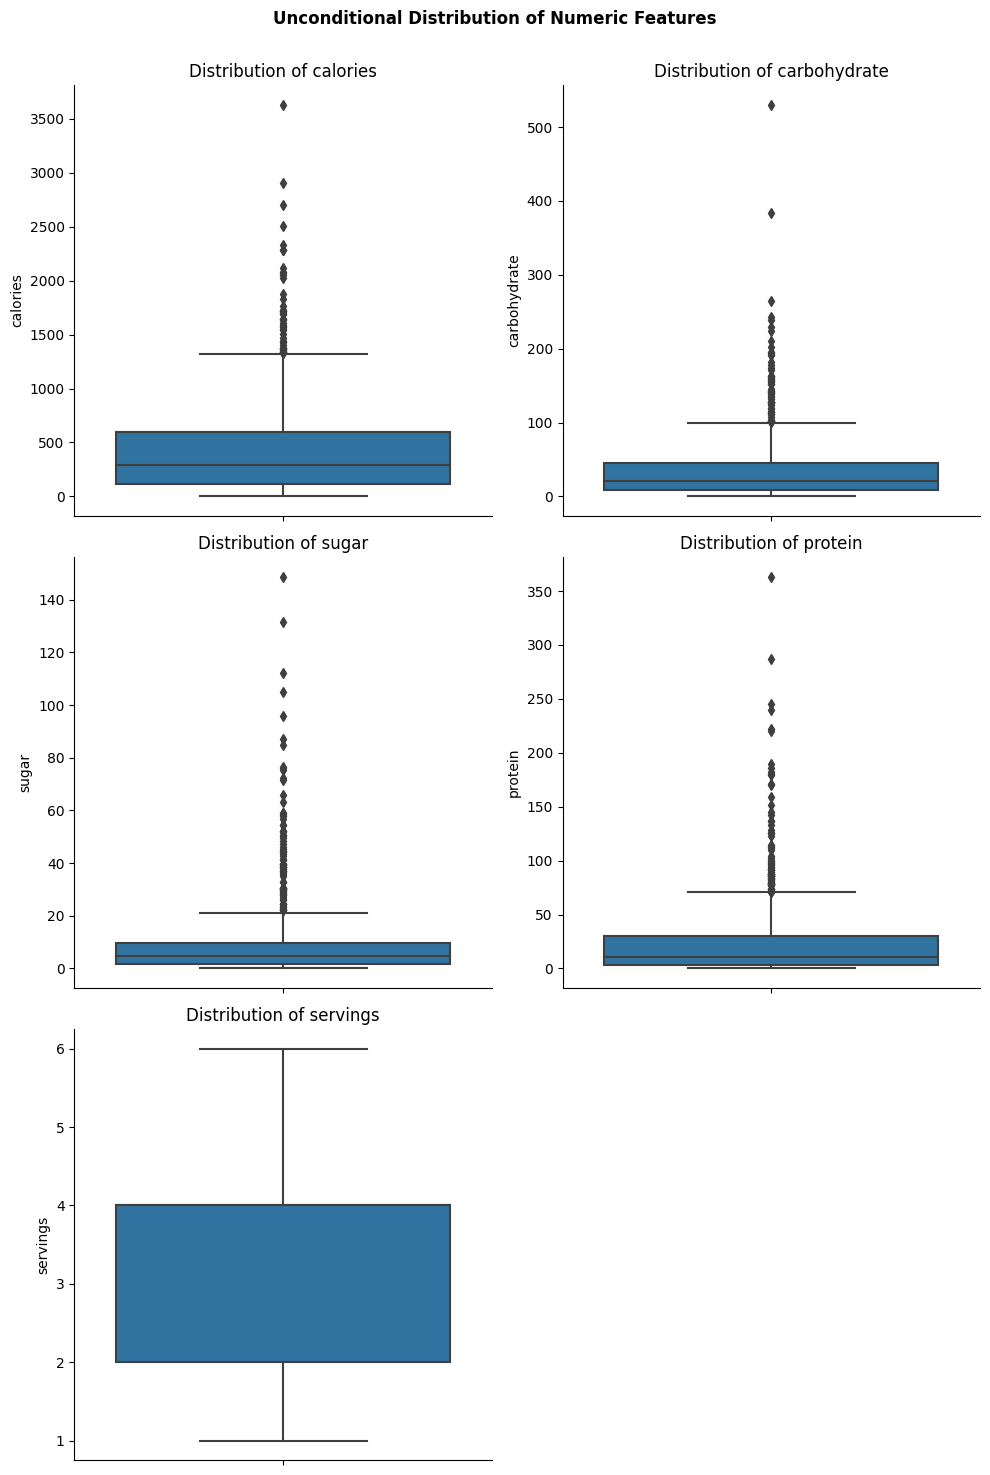

In [54]:
num_dist(data, num_features, 'boxplot')

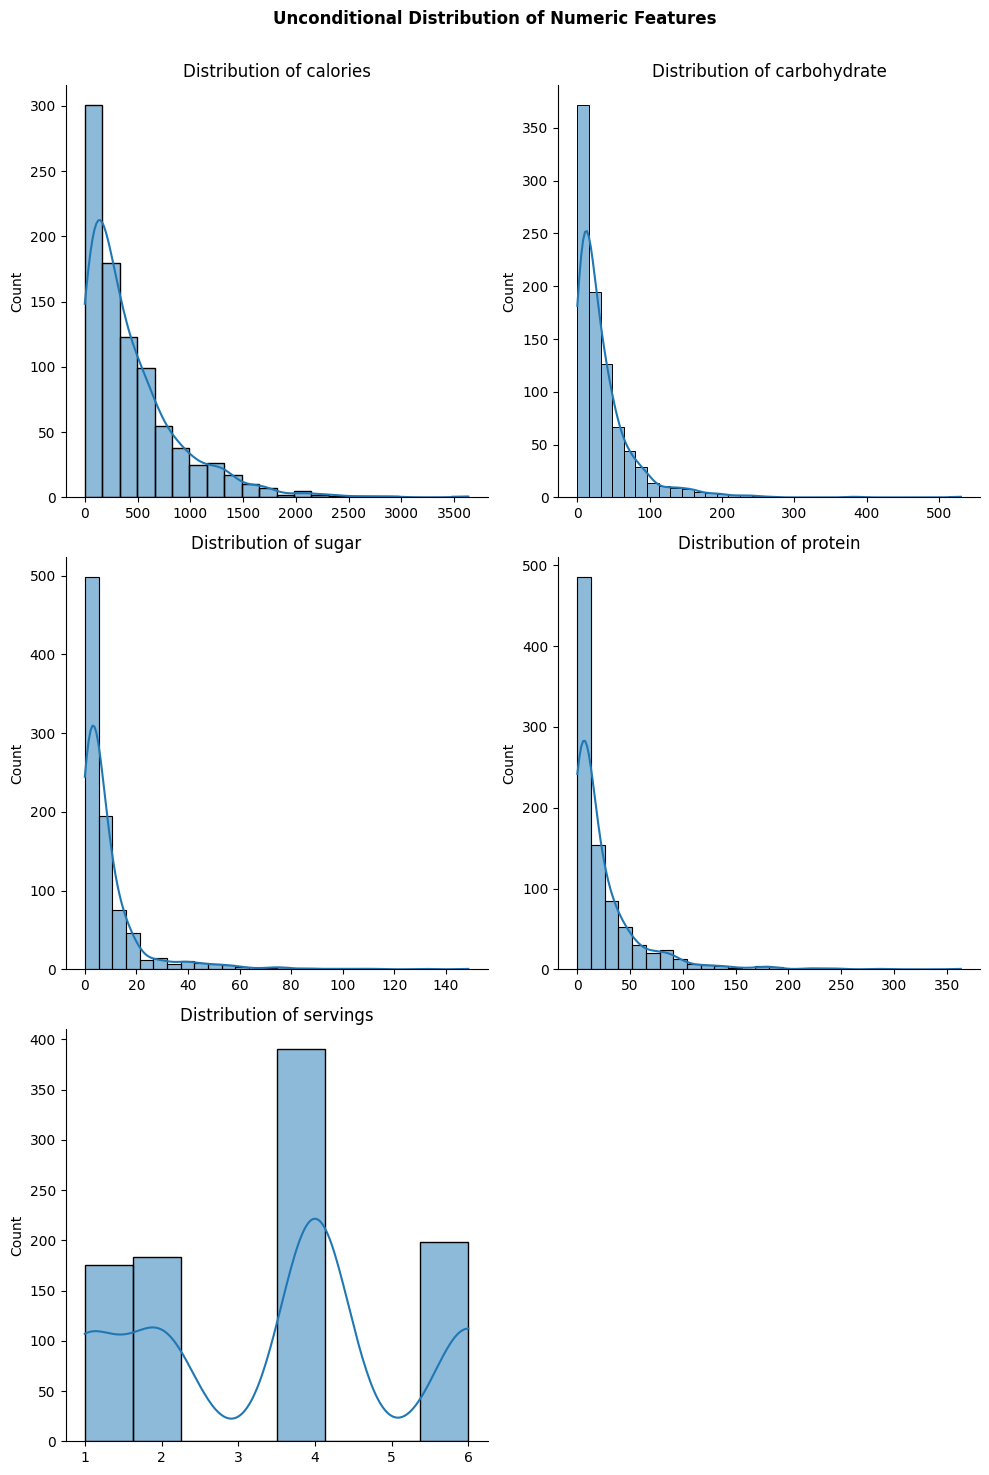

In [55]:
num_dist(data, num_features, 'histogram')

Within the conditional distributions on the target variable, we can observe any significant differences in the distributions given target is High or Low traffic. We expect that such features will not have a strong influence in predictions.

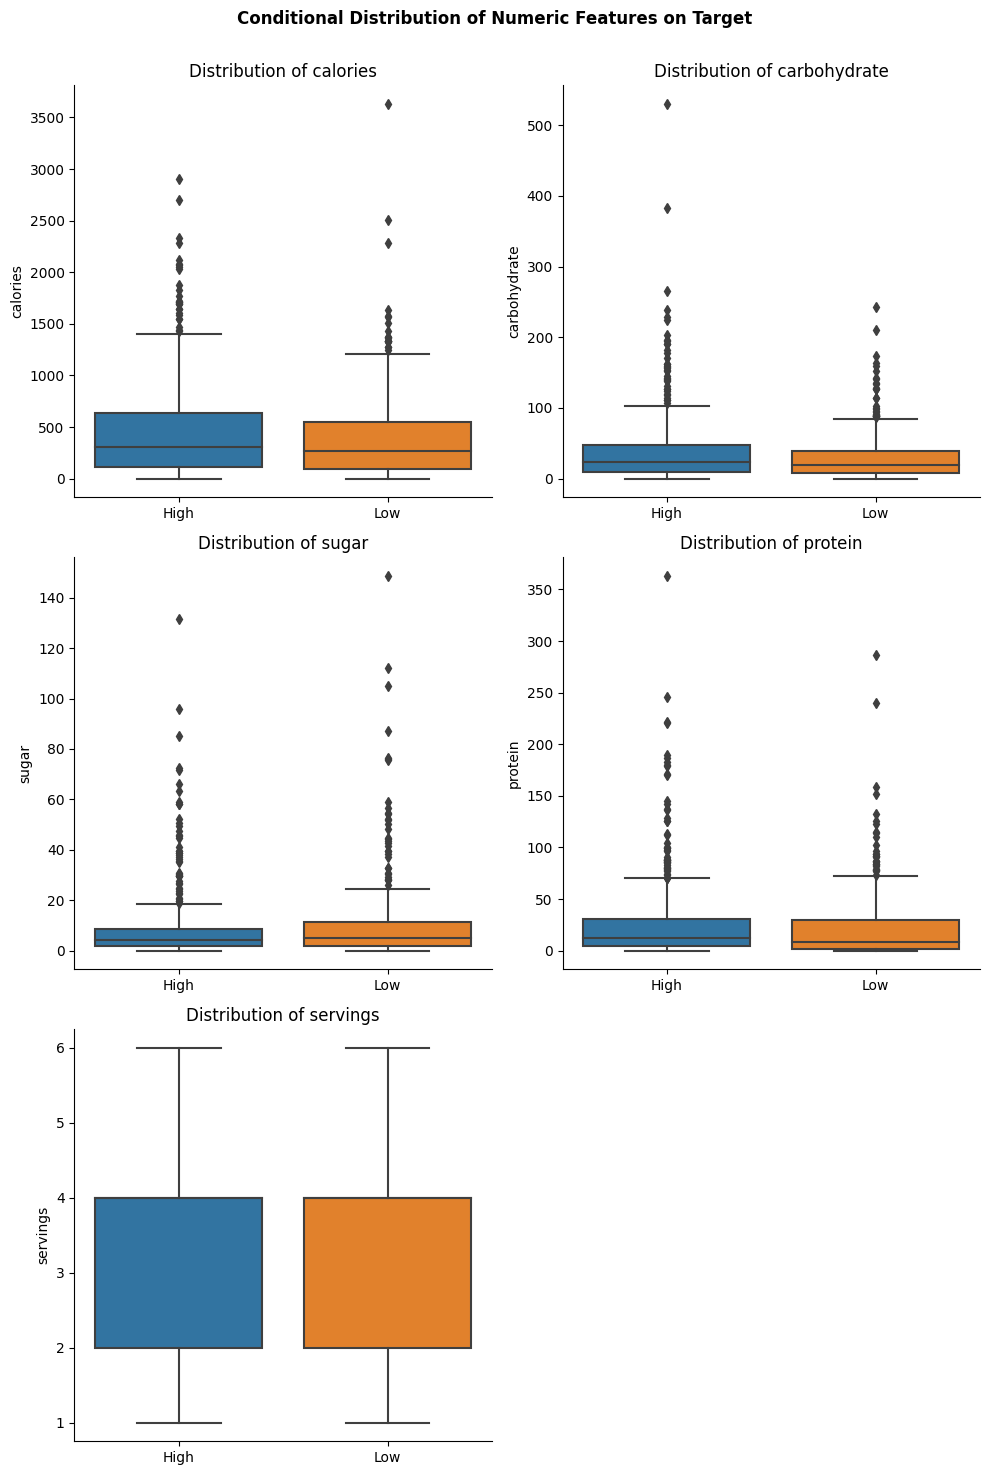

In [56]:
num_dist(data, num_features, 'boxplot', target)

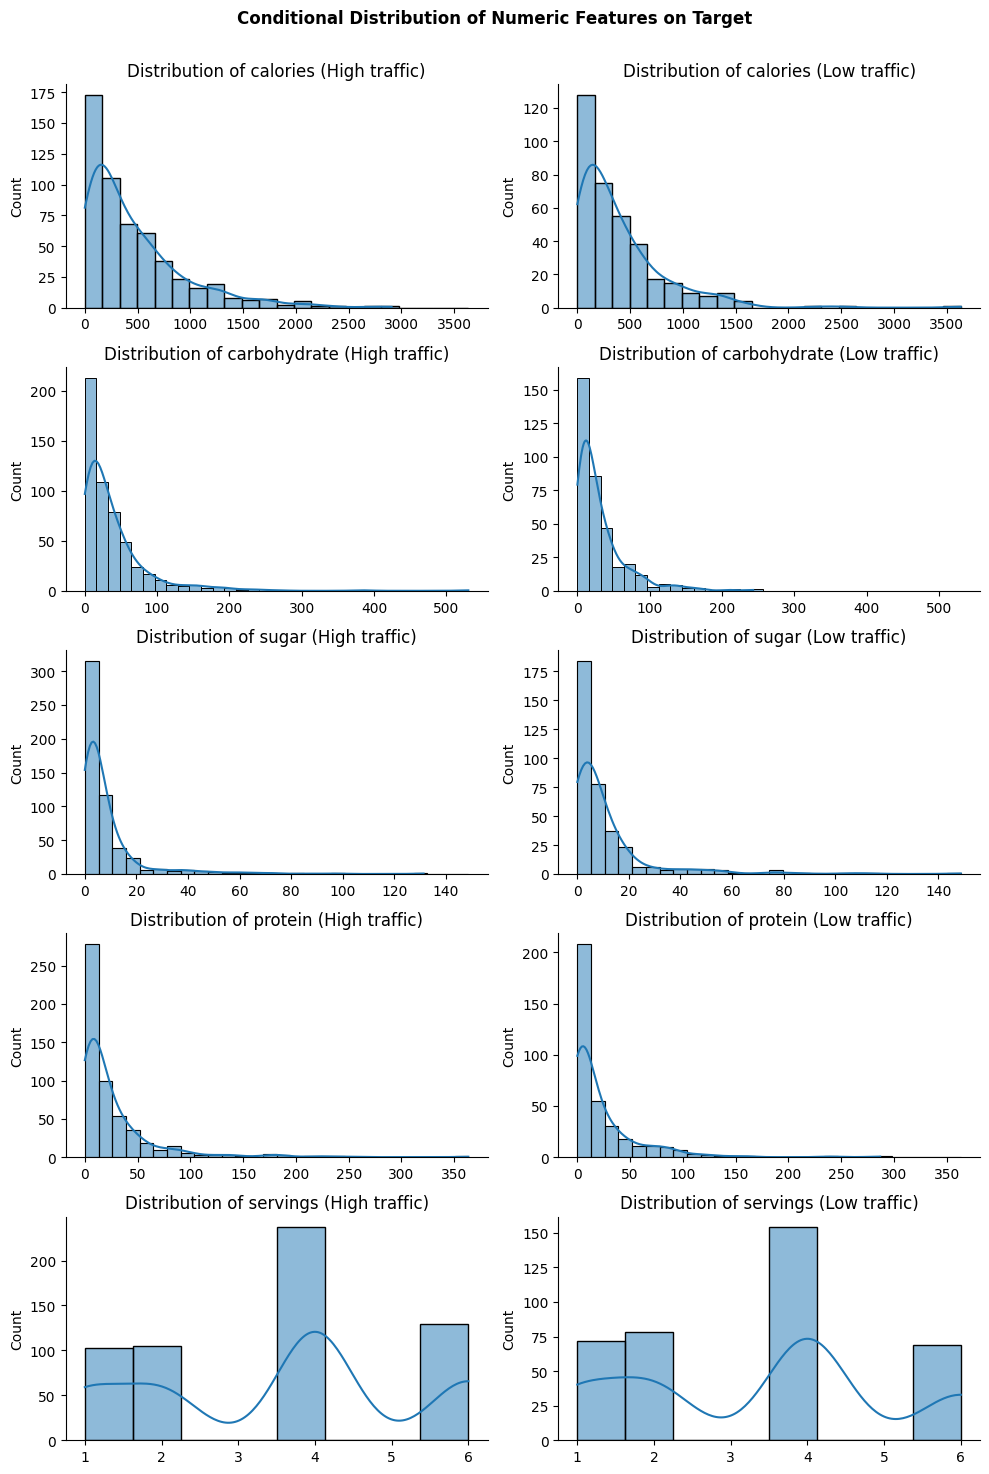

In [57]:
num_dist(data, num_features, 'histogram', target)

### Correlation Analysis

We also need to check the multicolinearity of the numerical features. We will measure such correlation with Pearson correlation as well as with the Spearman correlation, in order to capture both linear and nonlinear association.

In [58]:
def corr_matrix(data:pd.DataFrame, num_features:list, corr_method:str):
    
    plt.figure(figsize = (7, 6))
    
    #correlation matrix
    corrs = data[num_features].corr(method = corr_method)
    
    #mask for plotting only the correlation coefficients below the diagonal
    mask = np.triu(np.ones_like(corrs))
    
    sns.heatmap(corrs, vmin =-1, vmax = 1,
                annot = True, mask = mask)
    plt.title(f'{corr_method.capitalize()} Correlation Matrix of the Numeric features',
              fontweight = 'bold')
    
    plt.show()

As can be seen, none of the features are correlation with exception of protein and calories. However, such correlation is not much strong, hence we don't expect any issues.

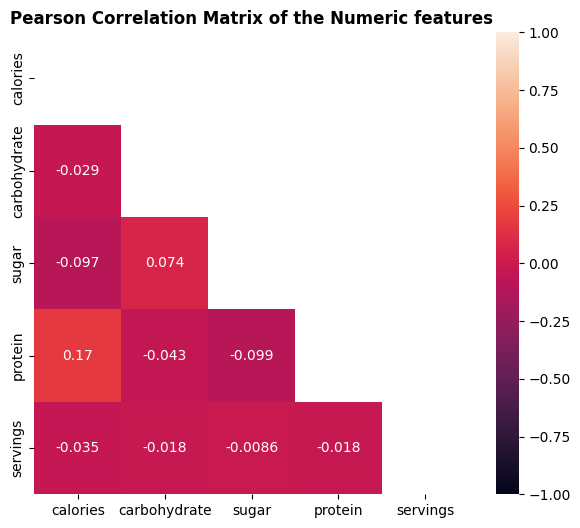

In [59]:
corr_matrix(data, num_features, 'pearson')

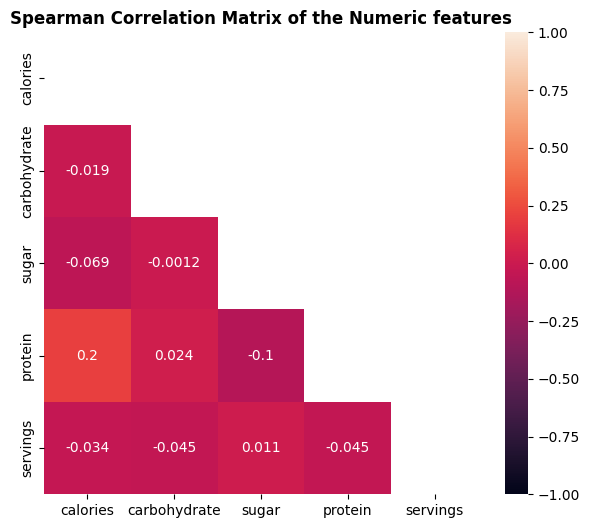

In [60]:
corr_matrix(data, num_features, 'spearman')

### Association between the target variable and the numerical features

We use a point biserial correlation coefficient which measures strength and direction of the relationship between the continuous feature and binary variable.
$$r_X = \frac{\mu \left(X \;\middle|\; Y = 1 \right) - \mu_X}{\sigma_X} \sqrt{\frac{\Pr \left(Y = 1 \right)}{1 - \Pr \left(Y = 1\right)}}$$

In [63]:
def point_biserial_corr(data, num_features, target, significance_level = 0.01):
    
    #priting options
    no_dashes = 100
    for col in num_features:
        print(f"{no_dashes*'-'}")
        print(f'Point Biseral Correlation between the {col.capitalize()} and {target.capitalize()}')
        print(f"{no_dashes*'-'}")
        
        temp_df = data[data[col].notna()].copy()
        temp_df[target] = temp_df[target].replace({'High': 1, 'Low': 0})
        coef, p_value = pointbiserialr(temp_df[target], temp_df[col])
        print(f'Point Biseral Correlation Coefficient: {coef}')
        print(f'p-value: {p_value}')
        print(f"{no_dashes*'-'}")
        
        result_significance = '' if float(p_value) <= significance_level else 'not '
        result_strength = 'weak' if float(coef) <= 0.3 else 'moderate' if float(coef) <= 0.5 else 'strong'
        significance_level_print = int(significance_level*100) if (significance_level*100).is_integer() else significance_level*100
        
        print(f"RESULT: The association is {result_strength} and is {result_significance}statistically significant on the {significance_level_print}% significance level.")
        print(f"{no_dashes*'-'}", '\n')
    

As can be seen, there don't seem to be any strong associations which was expected from the observed findings in the histogram/boxplot distributions.

In [64]:
point_biserial_corr(data, num_features, target)

----------------------------------------------------------------------------------------------------
Point Biseral Correlation between the Calories and High_traffic
----------------------------------------------------------------------------------------------------
Point Biseral Correlation Coefficient: 0.07438204017479884
p-value: 0.026065982071965213
----------------------------------------------------------------------------------------------------
RESULT: The association is weak and is not statistically significant on the 1% significance level.
---------------------------------------------------------------------------------------------------- 

----------------------------------------------------------------------------------------------------
Point Biseral Correlation between the Carbohydrate and High_traffic
----------------------------------------------------------------------------------------------------
Point Biseral Correlation Coefficient: 0.08093170187232109
p-value: 0.01

### N/A Analysis

There are 4 features having some N/A - calories, carbohydrate, sugar and protein.
- Suspiciously, all the features have the same number of N/A's.

In [65]:
data.isna().sum()

calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

It seems that all the N/A occurrences are pertaining to the same instances.
- Meaning that all the 52 NA's occurences regard the 52 individual recipes.

In [66]:
data[list(data.isna().sum(axis = 1) > 0)]

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,NaN,NaN,NaN,NaN,Pork,6,High
23,NaN,NaN,NaN,NaN,Meat,2,Low
48,NaN,NaN,NaN,NaN,Chicken,4,Low
82,NaN,NaN,NaN,NaN,Meat,4,High
89,NaN,NaN,NaN,NaN,Pork,6,High
116,NaN,NaN,NaN,NaN,Chicken,6,High
121,NaN,NaN,NaN,NaN,Dessert,2,High
136,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,NaN,NaN,NaN,NaN,Potato,2,High
187,NaN,NaN,NaN,NaN,Pork,4,High


Indeed, all the NA's occurences regard the 52 individual recipes.

In [67]:
data[list(data.isna().sum(axis = 1) > 0)].shape[0]

52

Function for plotting frequency table between the binary/categorical variable and the indicator whether there was a missing value for given instance (Yes = 'NA' / No = 'Available')

In [68]:
def NA_plot(data:pd.DataFrame, comparison_var, normalize:bool = False, base_var = 'calories'):
    #base_var = 'calories' - since the N/A's values are related to the same instances, we can pass any column name which does have a missing.
    
    #Creating an indicator whether there was a N/A for given row.
    temp_df = data.copy()
    temp_df['NA_ind'] = ['N/A' if pd.isnull(i) else 'Available' for i in data[base_var]]
    
    #Frequency table for N/A indicator and a single binary/category variable.
    if type(comparison_var) == str:
        
        plt.figure(figsize = (7, 6))
        
        #Normalize the frequencies on the row level.
        if normalize:
            sns.heatmap(pd.crosstab(temp_df[comparison_var],
                                    temp_df['NA_ind'])
                        .apply(lambda x: x/x.sum(), axis = 1),
                annot = True, vmin = 0, vmax = 0)
            
            plt.title(f"Normalized Frequency Table between the Missing Ocurrences and {comparison_var.capitalize()}",
                      fontweight = 'bold')
            
        #Just basic frequency table   
        else:
            sns.heatmap(pd.crosstab(temp_df[comparison_var], temp_df['NA_ind']),
                        annot = True, fmt = '.0f')
            
            plt.title(f"Frequency Table between the Missing Ocurrences and {comparison_var.capitalize()}",
                      fontweight = 'bold')
    
    #Frequency table for a binary variable (NA/ not NA) and the combination of categories of the binary/categorical variables passed within the list.
    elif type(comparison_var) == list:
        
        plt.figure(figsize = (5, 8))
        
        comparison_var_df = temp_df[comparison_var].apply(lambda x: x.str.cat(sep='_'), axis = 1)
        
        #The frequency values are normalized (on a row level). 
        if normalize:
            sns.heatmap(pd.crosstab(comparison_var_df,
                                    temp_df['NA_ind']).apply(lambda x: x/x.sum(), axis = 1),
                        annot = True,
                        vmin = 0,
                        vmax = 1)
            plt.title("Normalized frequency Table between  \n the Missing Ocurrences and Target with Category Feature",
                      fontweight = 'bold')
            
        #Just basic frequency table  
        else:
            sns.heatmap(pd.crosstab(comparison_var_df,
                                    temp_df['NA_ind']),
                        annot = True)
            plt.title("Frequency Table between the Missing Ocurrences and \n Target with Category Feature",
                      fontweight = 'bold')


    plt.show()

According to the frequency tables, there doesn't seem to be any pattern in terms of N/A's with respect to the target.

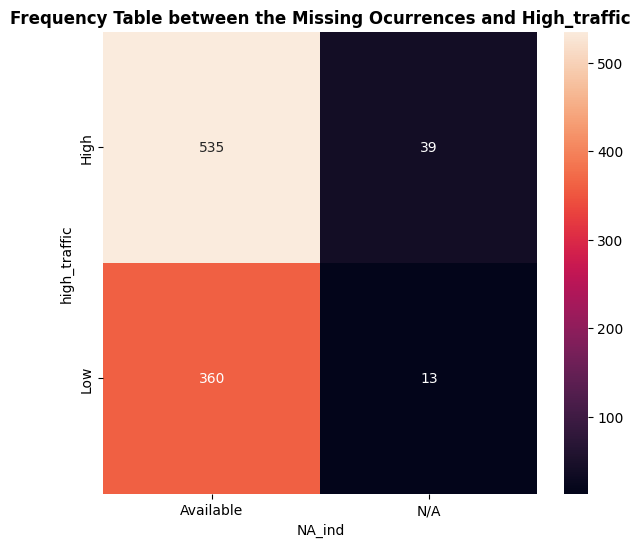

In [69]:
NA_plot(data, target)

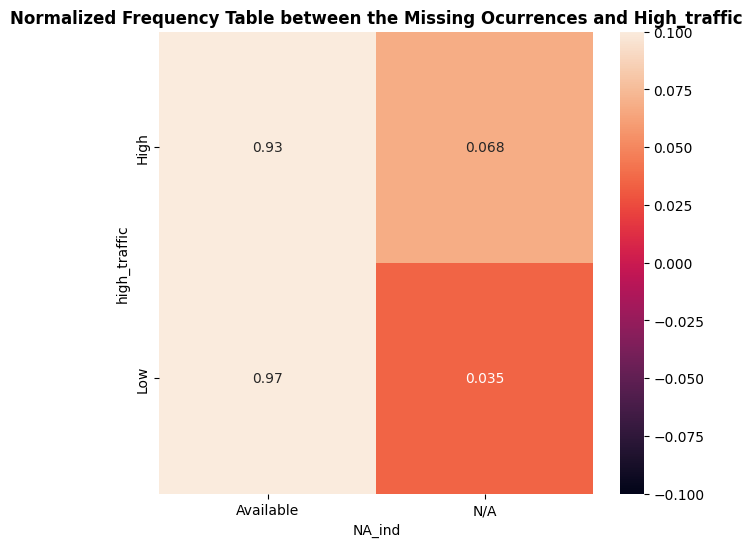

In [70]:
NA_plot(data, target, True)

According to the frequency tables, there doesn't seem to be any pattern in terms of N/A's with respect to the category feature.

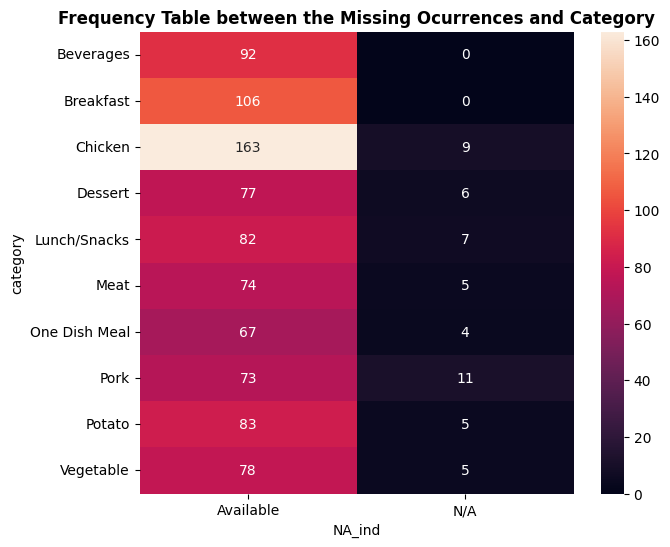

In [71]:
NA_plot(data, cat)

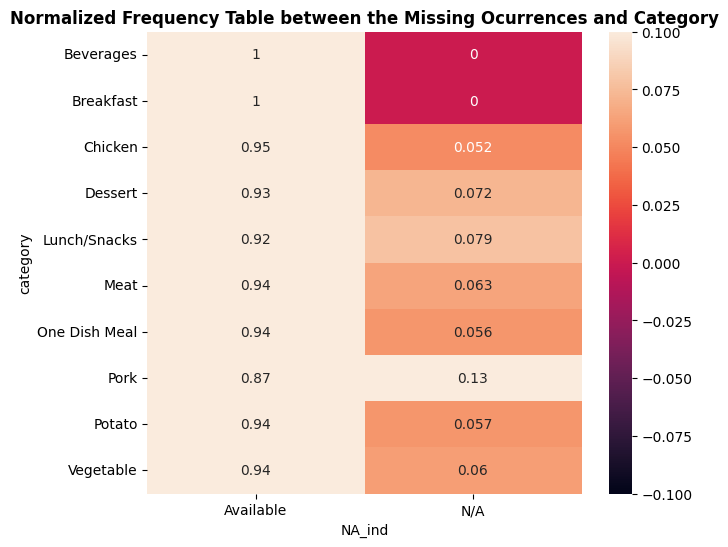

In [72]:
NA_plot(data, cat, True)

According to the frequency tables, there doesn't seem to be any pattern in terms of N/A's with respect to the combination of the target and category feature.

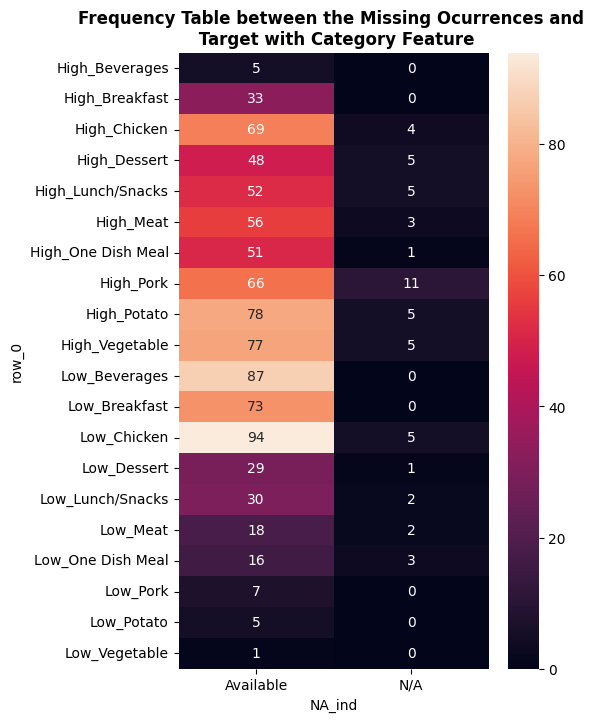

In [73]:
NA_plot(data, [target, cat])

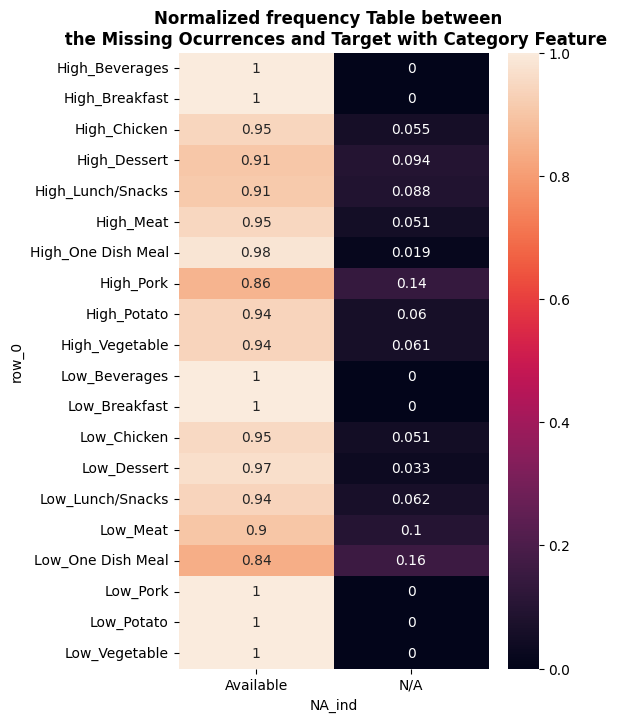

In [74]:
NA_plot(data, [target, cat], True)

Phi coefficient - metric for measurement between the binary variables:

$$\phi = \sqrt{\frac{\chi^2}{n}}$$

In [75]:
def phi_coefficient(var1, var2):
    
    cont_tab = pd.crosstab(var1, var2)
    
    chi2, *_ = chi2_contingency(cont_tab)
    n = cont_tab.sum().sum()
    
    phi = np.sqrt(chi2/n)
    
    return phi

There doesn't seem to be any strength association. between the N/A's and the target / category / target - category.

In [76]:
phi_coefficient(data[target], ['N/A' if pd.isnull(i) else 'Available' for i in data['calories']])

0.06623330867331152

In [77]:
cat_target_association(data[target],
                       ['N/A' if pd.isnull(i) else 'Available' for i in data['calories']])

----------------------------------------------------------------------------------------------------
Cramer's V: 0.06623330867331152
Chi squared statistic: 4.154348065390012
p-value: 0.041527757289053516
----------------------------------------------------------------------------------------------------
RESULT: The association is weak and is not statistically significant on the 1% significance level.
----------------------------------------------------------------------------------------------------


In [78]:
cat_target_association(data[cat],
                       ['N/A' if pd.isnull(i) else 'Available' for i in data['calories']])

----------------------------------------------------------------------------------------------------
Cramer's V: 0.15412937647621627
Chi squared statistic: 22.496803864221008
p-value: 0.007430988497378378
----------------------------------------------------------------------------------------------------
RESULT: The association is weak and is statistically significant on the 1% significance level.
----------------------------------------------------------------------------------------------------


In [79]:
cat_target_association(data[target] + '_' + data[cat],
                       ['N/A' if pd.isnull(i) else 'Available' for i in data['calories']])

----------------------------------------------------------------------------------------------------
Cramer's V: 0.18642390164388914
Chi squared statistic: 32.91191593561154
p-value: 0.024608557009567288
----------------------------------------------------------------------------------------------------
RESULT: The association is weak and is not statistically significant on the 1% significance level.
----------------------------------------------------------------------------------------------------


## Model Development
- **Data Split**
  - Converting the character target variable (high traffic) into binary (1/0).
  - Split into training set for hyperparameter tuning, training and optimal threshold calculation (80%), and into test set for model evaluation on unseen data (20%).
  - Split with stratification in order to preserve the same target distribution across the sets.
- **KNN Imputing**
  - Dataset had missing values, thus we needed to impute them.
  - Instead of imputing values with simple mean/mode/median, we used distance-weighted KNN with 5 nearest neighbors and Euclidean distance for imputing.
  - Since the missing values were observed only in numerical features, thus we imputed only the numerical features.
  - KNN Imputer fitted only on training set and was used for transformation of both training set and test set, in order to avoid the data leakage.
- **ADASYN Oversampling**
  - Our target variable distribution is imbalanced - majority of high traffic recipes over minority of low traffic recipes. The model would be biased by the majority class.
  - Oversampling was performed in order to get balanced distribution of the target variable.
  - Instead of using Random Oversampling which just duplicates minority instances, we used ADASYN (Adaptive Synthetic Sampling) as an extension to SMOTE (Synthetic Minority Oversampling Technique) which generates synthetic samples for the minority class by interpolating existing samples, using KNN.
  - Oversampling was performed on training set only in order to avoid the data leakage.
- **Weight of Evidence Encoding**
  - Since our dataset had 1 categorical feature, we need to encode such feature into numerical one.
  - One would use dummy (one-hot) encoding, but this approach is limited with curse of dimensionality when having a categorical feature with a lot of categories.
  - We used Weight of Evidence encoding, which encodes each category value of a categorical feature into numerical value while capturing its association to the target variable (such approach is commonly used within credit risk modelling).
    - Positive WoE coefficient indicates larger distribution of high traffic recipes within given category.
    - Negative WoE coefficient indicates larger distribution of low traffic recipes within given category.
    - Comparing to the conditional distribution of category feature, it is indeed true, since recipes with beverages leaded low traffic and had negative WoE coefficient, whereas recipes with vegetables leaded to the high traffic and had positive WoE coefficient.
  - The WoE Encoder fitted only on training set and was used for transformation of both training set and test set, in order to avoid the data leakage.
- **Standardization & Outliers Treatment**
  - Since our features had different scales (grams, WoE, number of servings etc.), we performed standardization using z-score.
  - With z-score values, we were able to identify outliers, if the absolute z-score values exceeded the threshold of 3 + standard deviation of given of such features.
  - The outliers were capped with 3 + standard deviation of given feature.
  - The Standard Scaler fitted on training set and was used for transformation of both training set and test set, in order to avoid the data leakage.
  - The same logic was applied for capping the outliers, where the standard deviation from training set was used.\
- **Hyperparameter tuning - Logistic Regression**
  - Since our goal is to predict, we used models from supervised learning.
  - Since our goal is to predict whether a recipe will lead to high traffic or not, we use classification model.
  - As a baseline model, we chose Logistic Regression from Scikit-Learn as a very traditional and transparent model.
  - Instead of fitting the model with default hyperparameters, we decided to tune its hyperparameters in order to boost the model performance.
  - Instead of using common Grid Search or Random Search, we used Bayesian Optimization from Scikit-Optimize which is faster than Grid Search and more efficient than Random search, as it is iteratively updating model's hyperparameters based on previous hyperparameter values considering its impact on the objective score function which we want to maximize. 
  - As an objective score function, we used Precision score since our goal is to correctly predict high traffic recipes at least 80% of the time.
    - Meaning that we want to maximize True Positive Rate while keeping the overall number of False Positives as low as possible.
    - Thus, we want to identify as many high traffic recipes as possible while (TP) while avoiding showing too many low traffic recipes on home page (FN).
  - For hyperparameter tuning, we used BayesSearchCV with 100 iterations and stratified 10 fold Cross Validation while maximizing Precision score.
  - We tuned following hyperparameters:
    - Intercept (Yes/No)
    - C (regularization strength)
    - Regularization type penalty,
    - Solver for optimization and estimation,
    - L1 ratio
  - The final model is Logistic Regression with following tuned hyperparameters:
    - Intercept (Yes)
    - C (regularization strength) of 0.000257
    - L2 regularization type penalty
    - Saga solver
    - L1 ratio of 1
- **Hyperparameter tuning - Neural Networks**
  - As a comparison model, we used Neural Networks from Keras which is the black box model and can deal with more complex data precisely and outperofrm  traditional models, but on the other hand is very complex and non-transparent.
  - We used Bayesian Optimization for tuning NN's hyperparameters from Keras Tuner.
  - Again, we want to maximize Precision score as an objective functions (since Precision score is not available in Keras, we had to define it by ourselves) within tunining hyperparameters.
  - We compile the model with Adam optimizer while minimizing binary cross entropy loss and maximizing Precision score.
  - We tuned the hyperparameters with Bayesian Optimization with 100 iterations, 100 epochs and early stopping callbacka after 7 epochs (if there is no improvement in Precision score).
  - By accessing the best hyperparameter values, we then fitted the final model with 100 epochs and early stopping callback after 7 epochs (if there is no improvement in the Precision score).
  - We tuned following hyperparameters:
    - Number of hidden blocks
      - Number of units in dense layer within each hidden block
      - Activation function type in dense layer within each hidden block
      - Kernel (L2) regularizer in dense layer within each hidden block
      - Activity (L2) regularizer in dense layer within each hidden block
      - Dropout rate in dropout layer within each hidden block
    - Learning rate of Adam optimizer
  - The final model is Logistic Regression with following tuned hyperparameters:
    - 10 hidden blocks
    - Learning rate of Adam optimizer of 0.0002875
    - For tuned hyperparameters' values within each hidden block, see the respective output.
  - In total, it has 532,740 parameters including the weights and biases.
- **Optimal Classification Threshold Calculation**
  - Instead of using a default classification threshold of 0.5, we calcualted an optimal threshold using Youden index, where we looked for such threshold which maximized the term _(True Positive Rate + True Negative Rate - 1)_.
    - True Negative rate is equivalent to _1 - False Positive Rate_. 
    - We calculated the optimal thresholds based on training set only in order to avoid data leakage.
  - The optimal thresholds are:
    - Logistic Regression: 0.47969
    - Neural Networks: 0.43828

### Stratified Data Split

Split data into training (80%) and test set (20%), with stratification in order to preserve the same distribution of the target variable across the sets.
- We also map the target values into 1/0 values as a suitable input for modelling.

In [80]:
def split_data(data: pd.DataFrame, target: str, test_size: float, seed: int,base_class: str = 'High'):
    
    data[target] = data[target].replace({"High":1, 'Low':0})
    
    Y = data[target]
    X = data.drop(target, axis = 1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify = Y, test_size = test_size, random_state = seed)
    
    return X_train.reset_index(drop = True), X_test.reset_index(drop = True), y_train.reset_index(drop = True), y_test.reset_index(drop = True)

In [81]:
test_size = 0.3
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [82]:
X_train_init, X_test_init, y_train_init, y_test_init = split_data(data, target, test_size, seed)

### KNN N/A imputing

Imputing the missing values with the KNN Imputer.
- Removing such rows with N/A's would lead to the loss of an information.
- Instead of just using a simple imputer with a mean/mode, we impute the missing values with K-Nearest Neighbours, particularly with distance-weighted points and by default with 5 nearest neighbours and Euclidean distance.
- Since we there are N/A's only at numerical features, we impute only numerical features.
- Noted that we fit the KNN Imputer on the training set and based on the fitted object, we then transform both training set and test set, in order to avoid data leakage.

In [83]:
def KNN_imputing(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, num_features: list):
    
    knnimp = KNNImputer(weights = 'distance')
    knnimp.fit(X_train[num_features], y_train)
    
    #Imputing the numerical features in both training and test sets.
    X_train_num_imputed = pd.DataFrame(knnimp.transform(X_train[num_features]), columns = num_features, index = X_train.index)
    X_test_num_imputed = pd.DataFrame(knnimp.transform(X_test[num_features]), columns = num_features, index = X_test.index)
    
    #Joining imputed numerical features and the categorical features in both training and test sets.
    X_train_imputed = pd.concat((X_train[cat_features], X_train_num_imputed), axis = 1).reindex(columns = X_train.columns)
    X_test_imputed =  pd.concat((X_test[cat_features], X_test_num_imputed), axis = 1).reindex(columns = X_test.columns)
    
    return X_train_imputed.reset_index(drop = True), X_test_imputed.reset_index(drop = True)

In [84]:
X_train_imputed, X_test_imputed = KNN_imputing(X_train_init, y_train_init, X_test_init, num_features)

As can be seen, there are no missing values anymore:

In [85]:
print('Training set:')
display(X_train_imputed.isna().sum())

print('Test set:')
display(X_test_imputed.isna().sum())

Training set:


calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
dtype: int64

Test set:


calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
dtype: int64

### ADASYN Oversampling

Since the target distribution is imbalanced, we decide to perform oversampling, meaning that we increase the number of minority instances (Low traffic) in order to balanced with the number majority instances (High traffic). Otherwise the model would be biased towards the majority class.
- Instead of using Random Oversampling which just duplicates minority instances, we perform a synthetic oversampling.
- We use ADASYN (Adaptive Synthetic Sampling) Oversampling as an extension to SMOTE (Synthetic Minority Oversampling Technique) which generates synthetic samples for the minority class by interpolating between existing samples, using K-Nearest Neighbors with 5 nearest neigbhors.
- Since ADASYN from imblearn cannot deal with the categorical features, we first "dummify" (one-hot encode) the categorical feature into numerical values, then perform oversampling and afterwads, we convert back the dummies into a single categorical feature.
- Noted that we perform oversampling on training set only, in order to avoid the data leakage.

In [86]:
def ADASYN_oversampling(X_train: pd.DataFrame, y_train: pd.Series,
                        seed: int, cat_features: list):
    
    adasyn = ADASYN(random_state = seed, n_jobs = -1)
    
    X_train_prep = X_train.copy()
    
    #One hot encoding of the categorical feature(s).
    for cat in cat_features:
        X_cat_dummies = pd.get_dummies(X_train_prep[cat], prefix = cat)
        X_train_prep = X_train_prep.drop(cat, axis = 1).copy()
        X_train_prep = pd.concat((X_train_prep, X_cat_dummies), axis = 1)
    
    #Oversampling with ADASYN
    X_train_os, y_train_os = adasyn.fit_resample(X_train_prep, pd.DataFrame(y_train).copy())
    
    #Converting back the dummies into categorical feature(s)
    for cat in cat_features:
        X_train_os[cat] = X_train_os.loc[:, [col for col in X_train_os.columns if cat in col]].idxmax(axis = 1).str.replace(f'{cat}_', '')
        X_train_os = X_train_os.drop([col for col in X_train_os.columns if f"{cat}_" in col], axis = 1)
    
    #Extracting the target from the data frame as a series
    y_train_os = y_train_os[target]
    
    #Re-order the data frame columns
    X_train_os = X_train_os.reindex(columns = X_train.columns)
    
    return X_train_os.reset_index(drop = True), y_train_os.reset_index(drop = True)

In [87]:
X_train_os, y_train_os = ADASYN_oversampling(X_train_imputed, y_train_init, seed, cat_features)

As can be seen, the distribution of the target after oversampling is almost balanced.

In [88]:
y_train_os.value_counts(normalize = True)

0    0.523187
1    0.476813
Name: high_traffic, dtype: float64

### WoE Encoding

We need convert the categorical feature(s) into numerical values.
- Instead of just simply using one-hot encoding or dummy encoding (this would result into a very high dimensionality which could bias the moded), we use Weight of Evidence encoding which is commonly used in credit risk modelling.
- It encodes the categorical features, respectively its categories into numerical values by capturing its relation to the target variable.
- Briefly, the WoE is calcualted for each category within the categorical feature and can be calculated like this:
$$WoE_{X, c}= \ln \left(\frac{\Pr{\left(X = c\;\middle|\;Y = 1\right)}}{\Pr{\left(X = c\;\middle|\;Y = 0\right)}}\right)$$
- If the WoE for given category is positive, it indicates the larger distribution of positive classes (High traffic) in given category tghan the negative classes (Low traffic) and vice versa.
- Noted, that we fit the WoE object on the training set only and then transform both training and test set, in order to avoid data leakage.

In [89]:
def WOE_encoding(X_train:pd.DataFrame, y_train:pd.Series,
                 X_test:pd.DataFrame, cat_features:list, seed:int):
    
    woe = WOEEncoder(cat_features, random_state = seed)
    woe.fit(X_train,y_train)
    
    X_train_final = woe.transform(X_train)
    X_test_final = woe.transform(X_test)
    
    return X_train_final.reset_index(drop = True), X_test_final.reset_index(drop = True)

In [90]:
X_train_woe, X_test_woe = WOE_encoding(X_train_os, y_train_os, X_test_imputed, cat_features, seed)

By comparing conditional distribution plots of category column and its WoE values, we can see that:
- Amongst the recipes with beverages, there are more recipes with low traffic, which is captured within a negative WoE.
- On the other hand, in the recipes with vegatables, there are more recipes with higher traffic, which is captured within a positive WoE.

In [91]:
def woe_plot(X_orig: pd.DataFrame, X_woe: pd.DataFrame, cat: str):
    
    df_plot = pd.concat((X_orig[[cat]],\
                         X_woe[[cat]].rename(columns = {cat: 'WoE'})),
                        axis  = 1).drop_duplicates()
    plt.figure(figsize = (7, 5))
    
    sns.barplot(data = df_plot, x = cat, y = 'WoE', color = 'blue')
    
    plt.axhline(y = 0, color = 'black', linestyle = '-', linewidth = 1)
    plt.xticks(rotation = 70)
    plt.title('WoE Distribution per category', fontweight = 'bold')
    
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    plt.show()

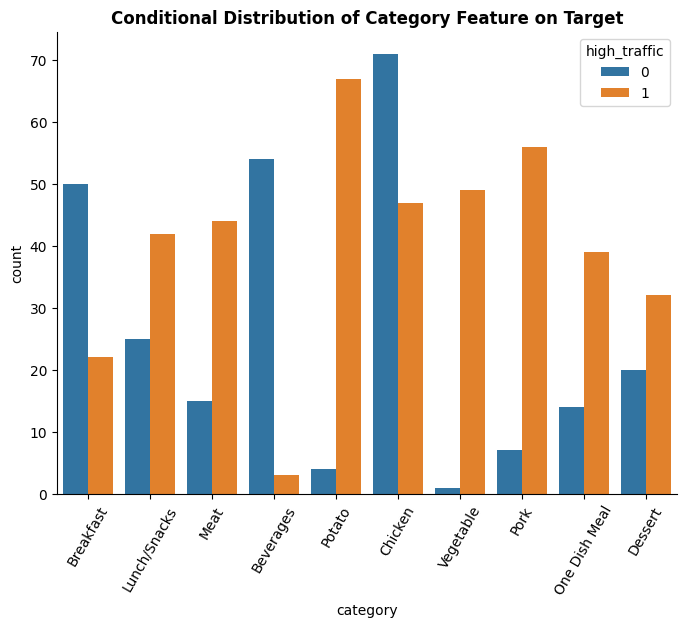

In [92]:
cat_dist(pd.concat((X_train_init, y_train_init), axis=1), cat, target)

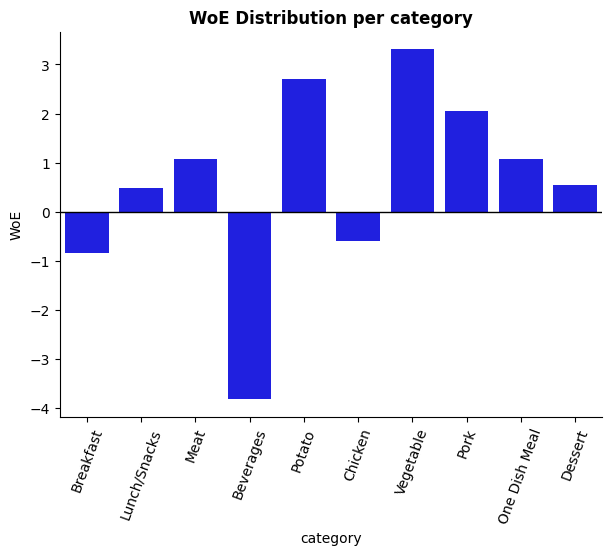

In [93]:
woe_plot(X_train_os, X_train_woe, cat)

### Standardization & Outliers Treatment

Since our features have different scales and cotain outliers, we perform a standardization of features.
- By standarization, we can detect outliers using the z-score:
$$Z = \frac{x - \mu}{\sigma}$$
- If the z-score in absolute value higher than 3, meaining the z-score is larger than 3 times of standard deviation from the mean, we deem such value as an outlier.
- With such default threshold of 3, we would lose some useful information by capping the higher values than 3 / lower values than -3 with 3 or -3 respectively.
- Instead, we choose a variable threshold where to each feature, we compare its absolute z-score to 3 + standard deviation of such feature.
- Noted that, we fit the standard scaler on the training set and then transform the training and test set, in order to avoid data leakage.
- Also, when removing outliers, we cap the outliers (if they exceed 3 + standard deviation) by comparing the value to the standard deviation from the training set (and not from test set), again in order to avoid data leakage, and we cap then with 3 + standard deviation from the training set.

In [94]:
def standard_scaling(X_train: pd.DataFrame, X_test: pd.DataFrame, num_features = None):

    sts = StandardScaler()
    sts.fit(X_train)

    X_train_scaled = pd.DataFrame(sts.transform(X_train), columns = X_train.columns)
    X_test_scaled = pd.DataFrame(sts.transform(X_test), columns = X_test.columns)
    
    #Capping the outliers
    for col in X_train_scaled.columns:
        X_train_scaled[col] = [(3 + np.std(X_train_scaled[col])) if np.abs(x) > (3 + np.std(X_train_scaled[col])) else x for x in X_train_scaled[col]]
        X_test_scaled[col] =  [(3 + np.std(X_train_scaled[col])) if np.abs(x) > (3 + np.std(X_train_scaled[col])) else x for x in X_test_scaled[col]]

    return X_train_scaled.reset_index(drop = True), X_test_scaled.reset_index(drop = True)

Yet our data are finally ready for modelling!

In [95]:
X_train_final, X_test_final = standard_scaling(X_train_woe, X_test_woe)

In [96]:
y_train_final, y_test_final = y_train_os, y_test_init

## Hyperparameter tuning - Logistic Regression

As a baseline model, we choose a logistic regression which is traditional and transparent model for classification (since our target is binary and our goal is to predict, thus supervised learning is used).
- Instead of using a model with default hyperparameter values, we tune its hyperparameters in order to increase the model's performance.
- Instead of using most common hyperparameter approaches such as grid search or random search, we use Bayesian optimization which is faster than grid search and more efficient than random search since it is iteratively updating its hyperparameter values based on previous values considering its impact on the objective function.
- Our objective function is Precision score function since our goal is to correctly predict high traffic recipes at least 80% of the time. Meaning that we want to maximize True Positive Rate while keeping the overall number of False Positives as low as possible, thus we want to identify as many high traffic recipes as possible while avoiding showing too many low traffic recipes
- Particularly, we tune whether a model should have intercept or not, the C as a regularization strength, penalty as a type of regularization, and solver as a approach of estimating the model coefficients and model optimization, and L1 ratio which is related to the penalty hyperparameter.
- We perform hyperparameter tuning with stratified 10 fold cross validation and 100 iterations while maximizing Precision score.

In [97]:
def lr_tuning(X_train: pd.DataFrame, y_train: pd.Series, seed: int):
    
    #Hyperparameter space
    search_space = {
                        "fit_intercept": Categorical([True, False]),
                        "C": Real(0.000001, 10, prior = "log-uniform"),
                        "penalty": Categorical(["l1", "l2", "none", "elasticnet"]),
                        "solver": Categorical(["lbfgs", "liblinear", "newton-cg", "sag", "saga"]),
                        "class_weight": Categorical(["balanced", None])
                        }

    for solver in ["lbfgs", "liblinear", "newton-cg", "sag", "saga"]:
        if solver == "lbfgs" or solver == "newton-cg":
            search_space["penalty"] = Categorical(["l2", "none"])
        elif solver == "sag":
            search_space["penalty"] = Categorical(["l2", "elasticnet"])
            search_space["l1_ratio"] = Real(0, 1, prior = "uniform")
        elif solver == "liblinear":
            search_space["penalty"] = Categorical(["l1", "l2", "none", "elasticnet"])
            if search_space["penalty"] == "l2":
                search_space["dual"] = Categorical([True, False])
        else:
            search_space["penalty"] = Categorical(["l1", "l2", "none", "elasticnet"])
            search_space["l1_ratio"] = Real(0, 1, prior = "uniform")
            search_space["solver"] = Categorical(["saga"])
            
    #Stratified 10 fold cross validation      
    stratified_cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = seed)
    
    #Bayesian optimization
    bayescv = BayesSearchCV(estimator = LogisticRegression(random_state = seed),
                            search_spaces = search_space,
                            scoring = 'precision', cv = stratified_cv,
                            n_jobs = -1, n_iter = 100,
                            random_state = seed, verbose = 0)
    
    #Hyperparameter tuning
    bayescv.fit(X_train, y_train)
    
    #Extracting the model with the best hyperparameter values
    final_lr = bayescv.best_estimator_
    
    #Fitting the final model
    final_lr.fit(X_train, y_train)
    
    print("Final model hyperparameters' values:", '\n')

    for hyp_name, hyp_value in final_lr.get_params().items():
        print(f'          {hyp_name}: {hyp_value}')

    return final_lr

In [98]:
lr_tuned = lr_tuning(X_train_final, y_train_final, seed)

Final model hyperparameters' values: 

          C: 0.0002574260154667374
          class_weight: None
          dual: False
          fit_intercept: True
          intercept_scaling: 1
          l1_ratio: 1.0
          max_iter: 100
          multi_class: auto
          n_jobs: None
          penalty: l2
          random_state: 42
          solver: saga
          tol: 0.0001
          verbose: 0
          warm_start: False


Those are the best hyperparameter values of Logistic Regression.

### Hyperparameter tuning - Neural Networks

The comparison model is the Neural Networks from Keras, which is the black box model and can deal with more complex data precisely and outperform traditional models, but on the other hand is very complex and non-transparent.
- Again, instead of using a default model, we tune its hyperparameters using Bayesian optimization.
- We want to maximize the Precision score, but since its not available in Keras, we need to define it by oursevels.
- We tune hyperparameters such as number of hidden (dense) blocks, number of units / activation function / kernel and activation regularizers in each dense layer, dropout rate within each hidden block, and learning rate of Adam optimizer.
- We compile such model while minimizing binary cross entropy loss and maximizing Precision score.
- We tune the hyperparameters with Bayesian optimization with 100 trials, 100 epochs and early stopping callback after 7 epochs (if there is no improvement in the Precision score).
- By accessing the best hyperparameter values, we then fit the final model with 100 epochs and early stopping callback after 7 epochs (if there is no improvement in the Precision score).

In [99]:
def nn_tuning(X: pd.DataFrame, y: pd.Series, seed: int):

    def precision(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        
        return precision
        
    #Function for building a model and tuning its hyperparameters.
    def model_building(hp):
        
        #Input layer - with n inputs where n is the number of features.
        inputs = Input(shape = (X.shape[1], ))
        x = inputs
        
        #Tuning the number of hidden (Dense) blocks within the neural networks.
        for i in range(hp.Int('Dense_layers', min_value = 1, max_value = 10)):
            
            #Tuning the number of units, activation type, kernel and activity regularizers within each dense layer.
            
            no_units = hp.Int(f'Dense_{i}' ,min_value = 5, max_value = 512, default = 50)
            activation = hp.Choice(f'Activation_{i}', ['relu','tanh'])
            
            kernel_regularizer = L2(hp.Float(f'KernelRegularizer_{i}',
                                                       min_value = 1e-10, max_value = 0.5,
                                                       sampling = 'log'))
            
            activity_regularizer = L2(hp.Float(f'ActivityRegularizer_{i}',
                                                         min_value = 1e-10, max_value = 0.5,
                                                         sampling = 'log'))
            x = Dense(units = no_units,
                      activation = activation,
                      kernel_regularizer = kernel_regularizer,
                      activity_regularizer = activity_regularizer)(x)
        
            #Tuning the dropout rate within each hidden block
            x = Dropout((hp.Float(f'Dropout_{i}', 0.000001, 0.5, sampling='log')))(x)

        #Output layer - sigmoid for binary classification.
        outputs = Dense(1, activation = 'sigmoid')(x)
        
        #Mapping the model's input and output layers
        model = Model(inputs, outputs, name = 'NN')
        
        #Compiling the model within Adam optimizer while minimzing binary cross entropy loss and maxizing Precision score.
        #Tuning the learning rate of the Adam optimizer
        model.compile(optimizer = Adam(hp.Float('LearningRate',
                                                                min_value = 1e-4,
                                                                max_value = 1e-2,
                                                                sampling='log')),
                      loss = 'binary_crossentropy', metrics = [precision])

        return model
    
    #Bayesian optimization of NN while maximizing Precision score with 100 iterations.
    bayes_opt = BayesianOptimization(model_building,
                                           Objective('precision', direction = 'max'),
                                           max_trials = 100, overwrite = True,
                                           seed = seed, project_name = 'Bayes_NN')
    
    callback = [EarlyStopping(monitor = 'precision', mode = 'max', patience = 7)]
    
    #Hyperparameter tuning with 100 epochs and early stopping callback after 7 epochs (if there is no improvement in the Precision score).
    bayes_opt.search(X, y, verbose = 0,
                 epochs = 100, callbacks = callback)
    
    #Extracting the model with the best hyperparameter values
    best_hypers = bayes_opt.get_best_hyperparameters(num_trials = 1)[0]
    final_nn = bayes_opt.hypermodel.build(best_hypers)
    
    #Final model fitting with 100 epochs and early stopping callback after 7 epochs (if there is no improvement in the Precision score).
    final_nn.fit(X, y, verbose = 0, epochs = 100, callbacks = callback)
    
    print("Final model hyperparameters' values:", '\n')
    for hyp_name, hyp_value in best_hypers.values.items():
        print(f'          {hyp_name}: {hyp_value}')
    
    return final_nn

In [100]:
nn_tuned = nn_tuning(X_train_final, y_train_final, seed)

2023-03-19 01:23:12.268117: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-19 01:23:12.268141: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-19 01:23:12.268159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (12bc75c3-10a0-405f-a40d-16aadefed00f): /proc/driver/nvidia/version does not exist
2023-03-19 01:23:12.268390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Final model hyperparameters' values: 

          Dense_layers: 10
          Dense_0: 58
          Activation_0: relu
          KernelRegularizer_0: 8.440931282146121e-08
          ActivityRegularizer_0: 5.207945136418082e-06
          Dropout_0: 0.0003692791180096905
          LearningRate: 0.00028752007894035673
          Dense_1: 26
          Activation_1: tanh
          KernelRegularizer_1: 9.039284100594258e-09
          ActivityRegularizer_1: 1.1827610008392685e-08
          Dropout_1: 0.006504771577735488
          Dense_2: 284
          Activation_2: relu
          KernelRegularizer_2: 9.951985344328595e-06
          ActivityRegularizer_2: 0.006809678182657746
          Dropout_2: 5.571564232206821e-05
          Dense_3: 303
          Activation_3: relu
          KernelRegularizer_3: 0.00015950098979933462
          ActivityRegularizer_3: 0.0003553860387613718
          Dropout_3: 0.0018066765329724991
          Dense_4: 410
          Activation_4: relu
          KernelRegulariz

Neural networks sctucture

In [101]:
nn_tuned.summary()

Model: "NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense_3 (Dense)             (None, 58)                406       
                                                                 
 dropout_2 (Dropout)         (None, 58)                0         
                                                                 
 dense_4 (Dense)             (None, 26)                1534      
                                                                 
 dropout_3 (Dropout)         (None, 26)                0         
                                                                 
 dense_5 (Dense)             (None, 284)               7668      
                                                                 
 dropout_4 (Dropout)         (None, 284)               0        

### Optimal classification threshold

Instead of using a default classification threshold of 0.5, we calcute an optimal threshold using Youden index, where we look for such threshold where the term (true positive rate + true negative rate - 1) is the highest.
- Noted that true negative rate is equivalent to (1 - false positive rate).
- Noted that we calculate the optimal threshold based on training set and not test set in order to avoid data leakage.

In [102]:
def calc_opt_threshold(model, x:pd.DataFrame, y:pd.Series) -> float:
    
    #Depending on the model type (scikit-learn/keras), the prediction of probabilities approaches are different.
    if type(model) == keras.engine.functional.Functional:
        y_scores = [i[0] for i in model.predict(x, verbose = 0)]    
    else:
        y_scores = model.predict_proba(x)[:, 1]

    fpr, tpr, thresholds = roc_curve(y, y_scores)
    youden_index = tpr + (1 - fpr) - 1
    threshold = thresholds[np.argmax(youden_index)]

    return threshold

As we can see the, the optimal thresholds are 0.47969 and 0.43828 respectively.

In [103]:
lr_threshold = calc_opt_threshold(lr_tuned, X_train_final, y_train_final)
lr_threshold

0.47969251434547033

In [104]:
nn_threshold = calc_opt_threshold(nn_tuned, X_train_final, y_train_final)
nn_threshold

0.43828273

## Evaluation
- For each model (LR, NN), we calculated several metrics such as Accuracy, Precision, Recall, F1 Score and further AUC, Somers' D, Kolmogorov-Smirnov, Brier Score Loss or Zero One Loss, in order to get wider overview about the performance of both models and ability to compare the models.
  - For metrics calculation, we used the optimal thresholds calculated within model development.
  - We can observe that Logistic Regression outperformed Neural Networks across all the metrics as it had higher score metrics and lower loss metrics than Neural Networks.
- For each model, we also constructed confusion matrix to visualize the distribution of predicted and true labels.
  - For confusion matrix construction, we used the optimal thresholds calculated within model development.
  - We can observe that Logistic Regression outperformed Neural Networks as it correctly predicted more high traffic recipes (TP) and low traffic recipes (TN) than Neural Networks which have misclassified more recipes (FP an FN).
- For each model, we also constructed ROC curve, to visualize which model perfoms better in terms of AUC.
  - We can observe that Logistic Regression outperformed Neural Networks as it covered more area under the ROC curve than Neural Networks which is quantified in the AUC score.
  - Though both models performed better than the random baseline model, thus bnoth models can distinguish betyween the low and high traffic recipes pretty well.
- Specifically for Logistic Regression, we also plot its beta coefficients' magnitudes in order to inspect the impact of individual features on model predictions.
  - The most important feature in terms of beta coefficients' magnitudes is the Category feature as expected.
    - As the beta coefficient is positive, meaning that the higher its standardized WoE value is, the higher probability of high traffic recipe.
      - The highest WoE values are related to recipes with vegetables or potatoes, which is in line with the findings from the exploratory analysis.
    - On the other hand, the lower its standardized WoE value is, the lower probability of high traffic recipe.
      - The lowest WoE values are related to recipes with beverages, which is in line with the findings from the exploratory analysis.
 - The numerical features don't seem to have a large impact on predictions as their beta coefficients are very low compared to the Category feature.
   - With an exception of Sugar feature, all thenbumerical features have positive beta coefficient - meaning that the higher standardized value is, the higher probability of high traffic recipe. 
- The final model is thus **LOGISTIC REGRESSION** as it had better metrics than Neural Networks and its Precision score exceeded 80% which is desirable.

### Evaluation metrics

Within the evaluation, we calculate the most commonly used metric such as Accuracy, Precision, Recall, F1 score or AUC. We also compute another metrics such as Kolmogorov-Smirnov distance or Somers' D which are commonly used in credit risk modelling, and further Brier Score Loss or Zero One Loss. With exception of loss functions, the higher metric score, the better model is.
- We evaluate the model on test set.

In [105]:
def evaluation_metrics(model, X: pd.DataFrame, y: pd.Series,
                       threshold: float, target: str) -> pd.DataFrame:
    #Metrics space
    metrics = {
                "F1": f1_score,
                "Precision": precision_score, 
                "Recall": recall_score, 
                "Accuracy": accuracy_score,
                "AUC": roc_auc_score,
                "Kolmogorov-Smirnov": ks_2samp, 
                "Somers D": somersd,
                "Brier Score Loss": brier_score_loss,
                "Zero-One Loss": zero_one_loss,
                }

    #Metrics type (some uses predicted probabilites, some uses predicted classes)
    probs_evs = ["AUC", "Brier Score Loss"]
    class_evs = ["Precision", "Recall", "F1", "Accuracy", "Zero-One Loss"]
    evs_list = []
    
    if type(model) == keras.engine.functional.Functional:
        y_scores = [i[0] for i in model.predict(X, verbose = 0)]
    else:
        y_scores = model.predict_proba(X)[:, 1]
    
    #predicted classes based on provided custom threshold.
    y_preds = pd.Series(y_scores).apply(lambda x: 1 if x > threshold else 0)
    
    #Calculate each metric based on provided model (its predicted probabilities/classes) and true labels.
    for metric_name, metric in metrics.items():
        if metric_name in probs_evs:
            evs_list.append([metric_name, metric(y, y_scores)])
        elif metric_name in class_evs:
            evs_list.append([metric_name, metric(y, y_preds)])
        elif metric_name == 'Somers D':
            evs_list.append([metric_name, metric(y, y_scores).statistic])
        elif metric_name == "Kolmogorov-Smirnov":
            X_Y_concat = pd.concat((y, X), axis = 1)
            X_Y_concat["prob"] =  y_scores
            evs_list.append([metric_name, metric(X_Y_concat.loc[X_Y_concat[target] == 1, "prob"],
                                                 X_Y_concat.loc[X_Y_concat[target] == 0, "prob"]).statistic])

    evaluation_df = pd.DataFrame(evs_list, columns = ["Metric", "Score"])

    return evaluation_df

In [106]:
nn_eval = evaluation_metrics(nn_tuned, X_test_final, y_test_final, nn_threshold, target)

In [107]:
nn_eval

,Metric,Score
0,F1,0.710448
1,Precision,0.734568
2,Recall,0.687861
3,Accuracy,0.659649
4,AUC,0.730646
5,Kolmogorov-Smirnov,0.382122
6,Somers D,0.461292
7,Brier Score Loss,0.287999
8,Zero-One Loss,0.340351


In [108]:
lr_eval = evaluation_metrics(lr_tuned, X_test_final, y_test_final, lr_threshold, target)

In [109]:
lr_eval

,Metric,Score
0,F1,0.787879
1,Precision,0.828025
2,Recall,0.751445
3,Accuracy,0.754386
4,AUC,0.846047
5,Kolmogorov-Smirnov,0.554449
6,Somers D,0.692093
7,Brier Score Loss,0.245560
8,Zero-One Loss,0.245614


In [110]:
def eval_comparison(eval_dict: dict):

    metrics = ['F1', 'Precision', 'Recall', 'Accuracy', 'AUC', 'Somers D', 'Kolmogorov-Smirnov', 'Brier Score Loss', 'Zero-One Loss']
    eval_df = pd.DataFrame({'Metric':metrics})
    
    for name, df in eval_dict.items():
        eval_df = eval_df.merge(df.rename(columns = {'Score': f'Score_{name}'}), on ='Metric')
        
    for metric in metrics:
        if 'Loss' in metric:
            eval_df.loc[eval_df['Metric'].isin([metric]),'Winner'] = eval_df.query('Metric == @metric')[[i for i in eval_df.columns if 'Score' in i]].idxmin(axis = 1).values[0].split('_')[1:]   
        else:
            eval_df.loc[eval_df['Metric'].isin([metric]),'Winner'] = eval_df.query('Metric == @metric')[[i for i in eval_df.columns if 'Score' in i]].idxmax(axis = 1).values[0].split('_')[1:]
    
    return eval_df

We see that Logistic Regression outperforms Neural Networks across the all metrics and even has Precision score over 80% which is desired.

In [111]:
evals_df = eval_comparison({'NN': nn_eval, 'LR':lr_eval})
evals_df

,Metric,Score_NN,Score_LR,Winner
0,F1,0.710448,0.787879,LR
1,Precision,0.734568,0.828025,LR
2,Recall,0.687861,0.751445,LR
3,Accuracy,0.659649,0.754386,LR
4,AUC,0.730646,0.846047,LR
5,Somers D,0.461292,0.692093,LR
6,Kolmogorov-Smirnov,0.382122,0.554449,LR
7,Brier Score Loss,0.287999,0.245560,LR
8,Zero-One Loss,0.340351,0.245614,LR


### Confusion matrix

As can be seen, Logistic Regression correctly predicts more high traffic recipes (TP) and low traffic recipes (TN) than Neural Networks which have misclassified more recipes (FP and FN).

In [112]:
def plot_conf_matrix(model, X: pd.DataFrame, y: pd.Series, threshold: int, model_name = ''): 
    
    if type(model) == keras.engine.functional.Functional:
        y_preds = [i[0] for i in model.predict(X, verbose = 0)]
    else:
        y_preds = model.predict_proba(X)[:, 1]
        
    y_preds = pd.Series(y_preds).apply(lambda x: 1 if x > threshold else 0)
        
    confm = pd.DataFrame(confusion_matrix(y,y_preds)).rename(
                                            columns = {0: 'Predicted - Low traffic',1: 'Predicted - High traffic'},
                                            index = {0: 'Actual - Low traffic', 1: 'Actual - High traffic'})
    
    plt.figure(figsize = (7, 5))
    sns.heatmap(confm, annot = True, fmt = '.0f')
    plt.title(f'Confusion matrix of {model_name}', fontweight = 'bold')
    plt.show()

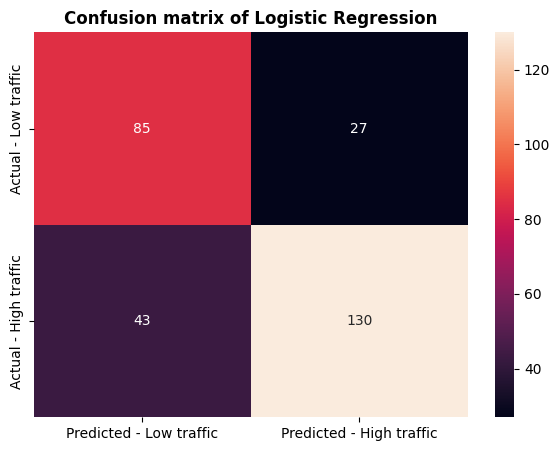

In [113]:
plot_conf_matrix(lr_tuned, X_test_final, y_test_final, lr_threshold, 'Logistic Regression')

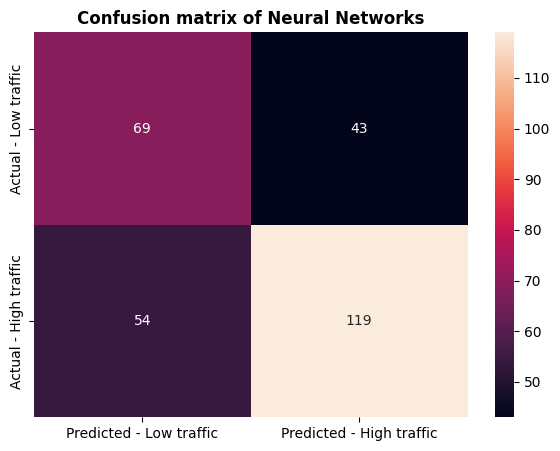

In [114]:
plot_conf_matrix(nn_tuned, X_test_final, y_test_final, nn_threshold, 'Neural Networks')

### ROC plot

As we can see, the Logistic Regression outpeforms Neural Networks as it covers more area under the ROC Curve, which is quantified in the AUC score. Though both models perform better than the random baseline model, thus both models can dinstinguish between the low and high traffic recipes.

In [115]:
def ROC_plot(model_dict: dict, X: pd.DataFrame, y: pd.Series):
    
    plt.figure(figsize=(6, 5))
    
    #For each model, plot the ROC curve.
    for name, model in model_dict.items():
        
        if type(model) == keras.engine.functional.Functional:
            y_pred = [i[0] for i in model.predict(X, verbose = 0)]
        else:
            y_pred = model.predict_proba(X)[:, 1]
            
        fpr, tpr, _ = roc_curve(y, y_pred)
        auc = roc_auc_score(y, y_pred)
        
        plt.plot(fpr, tpr, label=f"{name} ... AUC = {auc*100:.2f}%")

    plt.plot([0, 1], [0, 1], 'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC curves', fontweight = 'bold')
    
    plt.legend()
    plt.grid()
    
    axes = plt.gca()
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

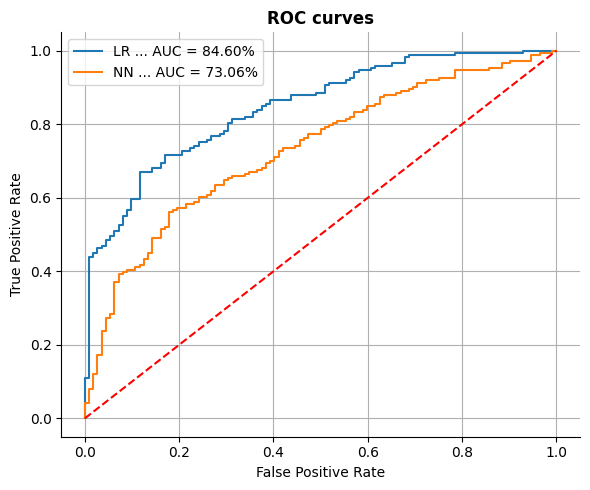

In [116]:
ROC_plot({'LR':lr_tuned, 'NN': nn_tuned}, X_test_final, y_test_final)

### Feature impact - Beta coefficients

In [117]:
def LR_coef_plot(lr_model, X: pd.DataFrame):
    
    coefs = pd.DataFrame([X.columns,lr_model.coef_.tolist()[0]]).transpose().rename(columns = {0: 'Feature', 1:'Beta'})
    
    fig, ax = plt.subplots(figsize = (7, 5))
    sns.barplot(data = coefs, y = 'Feature', x = 'Beta', ax = ax)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 9, rotation = 90)
    plt.title('Logistic regression - beta coefficients', fontweight = 'bold')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('Beta coefficients')
    plt.ylabel('Feature names')
    
    plt.axvline(x = 0, color = 'black', linewidth = 0.7)
    
    plt.show()

We see that Category feature has the biggest impact on predictions using Logistic Regression. As the beta coefficient is positive, meaning the higher standardized WoE value, the higher probability of that recipe will lead to the high traffic. The highest WoE values are related to recipes with vegetables or potatoes, which is in line with the findings from the exploratory analysis.

On the other hand, the lower its standardized WoE value is, the lower probability of high traffic recipe. The lowest WoE values are related to recipes with beverages, which is in line with the findinfs from the exploratory analysis.

The numerical features don't seem to have a large impact on predictions as their beta coefficients are very low compared to the Category feature. With an exception of Sugar feature, all the nbumerical features have positive beta coefficient - meaining that the higher standardized value is, the higher probability of high traffic recipe. 

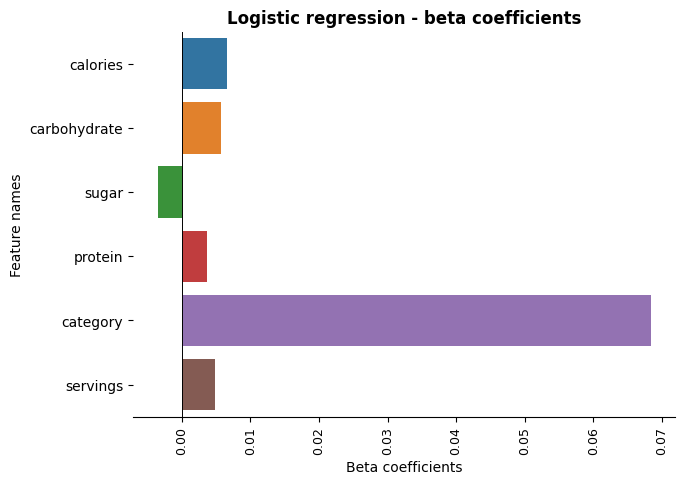

In [118]:
LR_coef_plot(lr_tuned, X_test_final)

As is it obvious that Logistic Regression outperforms Neural Networks, thus the Logistic Regression is the final model!

# Final Summary

## Data Validation
- ✔️ All the columns have been validated.
- ✔️ No duplicates were found.
- ✔️ All the recipes (and the recipes' ID's) are unique.
- ✔️ All the numerical columns are non-negative.
- ✔️ Target variable (high_traffic) and Category feature are indeed character.
- ❌ Invalid category value in Category feature - "Chicken Breast".
   - ✔️ Such category value was merged with the category "Chicken".
- ❌ Invalid data type of Servings feature - was encoded as character instead of numeric.
- ❌ Invalid values in Servings feature - instead of numbers, there were 2 values "4 as a snack" and "6 as a snack".
   - ✔️ Such values were merged with values "4" and "6" respectively.
   - ✔️ Conversion from character to numeric.
- ✔️ Target variable (High traffic) had missing values indicating no high traffic.
   - ✔️ Thus, we replace the missing values with 'Low'.
- ✔️ Recipe ID column was dropped from the dataset, since it wouldn't bring any useful information for modelling.

## Exploratory Analysis
- **Target variable distribution (High traffic)**
  - Imbalanced distribution - 60.6% of high traffic recipes ands 39.4% of low traffic recipes.
- **Category feature**
  - Most of the recipes included chicken (172 out of 947).
  - Most of the recipes including pork, potatoes vegetables or meat mostly leaded to the website's high traffic.
  - Most of the recipes including breakfast, beverages or chicken mostly didn't lead to the website's high traffic.
  - We expect such categories will help us to distinguish the high traffic and low traffic recipes within modelling.
  - Moderate and statistically significant association between the high traffic and the category.
- **Numerical features**
  - Servings features is discrete, whereas other numerical features (calories, carbohydrate, sugar, protein) are continuous.
  - Most of the recipes were meant for 4 servings.
  - Most of the recipes had very low level of either calories, carbohydrate, sugar and/or protein (their distributions were positively skewed.)
  - No pattern were found in terms of relation to high traffic.
  - Very weak and statistically insignificant association between the high traffic and the numerical features.
  - No multicolinearity observed.
- **N/A analysis**
  - 4 features (calories, carbohydrate, sugar and protein) had missing values (52).
  - 52 recipes had missing values - all the N/A's pertained to the same recipes.
  - Very weak and statistically insignificant association between the missing occurrences and the target variable.

## Model Development
- **Data Split**
  - Converting the character target variable (high traffic) into binary (1/0).
  - Split into training set for hyperparameter tuning, training and optimal threshold calculation (80%), and into test set for model evaluation on unseen data (20%).
  - Split with stratification in order to preserve the same target distribution across the sets.
- **KNN Imputing**
  - Dataset had missing values, thus we needed to impute them.
  - Instead of imputing values with simple mean/mode/median, we used distance-weighted KNN with 5 nearest neighbors and Euclidean distance for imputing.
  - Since the missing values were observed only in numerical features, thus we imputed only the numerical features.
  - KNN Imputer fitted only on training set and was used for transformation of both training set and test set, in order to avoid the data leakage.
- **ADASYN Oversampling**
  - Our target variable distribution is imbalanced - majority of high traffic recipes over minority of low traffic recipes. The model would be biased by the majority class.
  - Oversampling was performed in order to get balanced distribution of the target variable.
  - Instead of using Random Oversampling which just duplicates minority instances, we used ADASYN (Adaptive Synthetic Sampling) as an extension to SMOTE (Synthetic Minority Oversampling Technique) which generates synthetic samples for the minority class by interpolating existing samples, using KNN.
  - Oversampling was performed on training set only in order to avoid the data leakage.
- **Weight of Evidence Encoding**
  - Since our dataset had 1 categorical feature, we need to encode such feature into numerical one.
  - One would use dummy (one-hot) encoding, but this approach is limited with curse of dimensionality when having a categorical feature with a lot of categories.
  - We used Weight of Evidence encoding, which encodes each category value of a categorical feature into numerical value while capturing its association to the target variable (such approach is commonly used within credit risk modelling).
    - Positive WoE coefficient indicates larger distribution of high traffic recipes within given category.
    - Negative WoE coefficient indicates larger distribution of low traffic recipes within given category.
    - Comparing to the conditional distribution of category feature, it is indeed true, since recipes with beverages leaded low traffic and had negative WoE coefficient, whereas recipes with vegetables leaded to the high traffic and had positive WoE coefficient.
  - The WoE Encoder fitted only on training set and was used for transformation of both training set and test set, in order to avoid the data leakage.
- **Standardization & Outliers Treatment**
  - Since our features had different scales (grams, WoE, number of servings etc.), we performed standardization using z-score.
  - With z-score values, we were able to identify outliers, if the absolute z-score values exceeded the threshold of 3 + standard deviation of given of such features.
  - The outliers were capped with 3 + standard deviation of given feature.
  - The Standard Scaler fitted on training set and was used for transformation of both training set and test set, in order to avoid the data leakage.
  - The same logic was applied for capping the outliers, where the standard deviation from training set was used.\
- **Hyperparameter tuning - Logistic Regression**
  - Since our goal is to predict, we used models from supervised learning.
  - Since our goal is to predict whether a recipe will lead to high traffic or not, we use classification model.
  - As a baseline model, we chose Logistic Regression from Scikit-Learn as a very traditional and transparent model.
  - Instead of fitting the model with default hyperparameters, we decided to tune its hyperparameters in order to boost the model performance.
  - Instead of using common Grid Search or Random Search, we used Bayesian Optimization from Scikit-Optimize which is faster than Grid Search and more efficient than Random search, as it is iteratively updating model's hyperparameters based on previous hyperparameter values considering its impact on the objective score function which we want to maximize. 
  - As an objective score function, we used Precision score since our goal is to correctly predict high traffic recipes at least 80% of the time.
    - Meaning that we want to maximize True Positive Rate while keeping the overall number of False Positives as low as possible.
    - Thus, we want to identify as many high traffic recipes as possible while (TP) while avoiding showing too many low traffic recipes on home page (FN).
  - For hyperparameter tuning, we used BayesSearchCV with 100 iterations and stratified 10 fold Cross Validation while maximizing Precision score.
  - We tuned following hyperparameters:
    - Intercept (Yes/No)
    - C (regularization strength)
    - Regularization type penalty,
    - Solver for optimization and estimation,
    - L1 ratio
  - The final model is Logistic Regression with following tuned hyperparameters:
    - Intercept (Yes)
    - C (regularization strength) of 0.000257
    - L2 regularization type penalty
    - Saga solver
    - L1 ratio of 1
- **Hyperparameter tuning - Neural Networks**
  - As a comparison model, we used Neural Networks from Keras which is the black box model and can deal with more complex data precisely and outperofrm  traditional models, but on the other hand is very complex and non-transparent.
  - We used Bayesian Optimization for tuning NN's hyperparameters from Keras Tuner.
  - Again, we want to maximize Precision score as an objective functions (since Precision score is not available in Keras, we had to define it by ourselves) within tunining hyperparameters.
  - We compile the model with Adam optimizer while minimizing binary cross entropy loss and maximizing Precision score.
  - We tuned the hyperparameters with Bayesian Optimization with 100 iterations, 100 epochs and early stopping callbacka after 7 epochs (if there is no improvement in Precision score).
  - By accessing the best hyperparameter values, we then fitted the final model with 100 epochs and early stopping callback after 7 epochs (if there is no improvement in the Precision score).
  - We tuned following hyperparameters:
    - Number of hidden blocks
      - Number of units in dense layer within each hidden block
      - Activation function type in dense layer within each hidden block
      - Kernel (L2) regularizer in dense layer within each hidden block
      - Activity (L2) regularizer in dense layer within each hidden block
      - Dropout rate in dropout layer within each hidden block
    - Learning rate of Adam optimizer
  - The final model is Logistic Regression with following tuned hyperparameters:
    - 10 hidden blocks
    - Learning rate of Adam optimizer of 0.0002875
    - For tuned hyperparameters' values within each hidden block, see the respective output.
  - In total, it has 532,740 parameters including the weights and biases.
- **Optimal Classification Threshold Calculation**
  - Instead of using a default classification threshold of 0.5, we calcualted an optimal threshold using Youden index, where we looked for such threshold which maximized the term _(True Positive Rate + True Negative Rate - 1)_.
    - True Negative rate is equivalent to _1 - False Positive Rate_. 
    - We calculated the optimal thresholds based on training set only in order to avoid data leakage.
  - The optimal thresholds are:
    - Logistic Regression: 0.47969
    - Neural Networks: 0.43828
 
 ## Evaluation
- For each model (LR, NN), we calculated several metrics such as Accuracy, Precision, Recall, F1 Score and further AUC, Somers' D, Kolmogorov-Smirnov, Brier Score Loss or Zero One Loss, in order to get wider overview about the performance of both models and ability to compare the models.
  - For metrics calculation, we used the optimal thresholds calculated within model development.
  - We can observe that Logistic Regression outperformed Neural Networks across all the metrics as it had higher score metrics and lower loss metrics than Neural Networks.
- For each model, we also constructed confusion matrix to visualize the distribution of predicted and true labels.
  - For confusion matrix construction, we used the optimal thresholds calculated within model development.
  - We can observe that Logistic Regression outperformed Neural Networks as it correctly predicted more high traffic recipes (TP) and low traffic recipes (TN) than Neural Networks which have misclassified more recipes (FP an FN).
- For each model, we also constructed ROC curve, to visualize which model perfoms better in terms of AUC.
  - We can observe that Logistic Regression outperformed Neural Networks as it covered more area under the ROC curve than Neural Networks which is quantified in the AUC score.
  - Though both models performed better than the random baseline model, thus bnoth models can distinguish betyween the low and high traffic recipes pretty well.
- Specifically for Logistic Regression, we also plot its beta coefficients' magnitudes in order to inspect the impact of individual features on model predictions.
  - The most important feature in terms of beta coefficients' magnitudes is the Category feature as expected.
    - As the beta coefficient is positive, meaning that the higher its standardized WoE value is, the higher probability of high traffic recipe.
      - The highest WoE values are related to recipes with vegetables or potatoes, which is in line with the findings from the exploratory analysis.
    - On the other hand, the lower its standardized WoE value is, the lower probability of high traffic recipe.
      - The lowest WoE values are related to recipes with beverages, which is in line with the findings from the exploratory analysis.
 - The numerical features don't seem to have a large impact on predictions as their beta coefficients are very low compared to the Category feature.
   - With an exception of Sugar feature, all thenbumerical features have positive beta coefficient - meaning that the higher standardized value is, the higher probability of high traffic recipe. 
- The final model is thus **LOGISTIC REGRESSION** as it had better metrics than Neural Networks and its Precision score exceeded 80% which is desirable.

## Business Focus & Metrics

Regarding our business goals, we have to:
- predict which recipes will lead to website's high traffic
- correctly predict high traffic recipes 80% of the time

Since our final model, Logistic Regression, can distinguish between the high-traffic and low-traffic recipes pretty well and had objective Precision score higher than 80%, thus we can conclude that we acheive both goals.

As KPI's, I would monitor over time:
- number of subscriptions
- traffic of the website
- number of recipes with high/low traffic
- model performance

## Recommendations

- Final fitting of the model on the whole dataset before the deployment into a production
- Regularly recalibrate the model on the newest data (including the target).
- Increase sample size. model could then generalize better.
- Use other features: .e.g, number of steps, cooking time, ingredients, costs, occasion type, etc.
- Try more sophisticated hyperparemter tuning or model building (for instance, using Optuna or H2O Auto ML)

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation